In [175]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import seaborn as sns
from patsy import dmatrix, build_design_matrices
from scipy.stats import multivariate_normal
from itertools import cycle
import re
from scipy.linalg import pinv
from scipy.integrate import simpson
from scipy.stats import spearmanr

sns.set_theme()
sns.set_context("notebook")

In [176]:
dtype_dict = {
    'Date': 'str',
    'FarmName_Pseudo': 'str',
    'SE_Number': 'str',
    'Age': 'Int64',
    'BreedName': 'str',
    'DailyYield': 'float',
    'PreviousDailyYield': 'float',
    'DailyYieldChange': 'float',
    'DaysInMilk': 'Int64',
    'YearSeason': 'str',
    'LactationNumber': 'Int64',
    'ExpectedYield': 'float',
    'NormalizedDailyYield': 'float',
    'NormalizedDailyYieldChange': 'float',
    'HeatStress': 'Int64',
    'Temp15Threshold': 'Int64',
    'HW': 'Int64',
    'cum_HW': 'Int64',
    'MeanTemperature': 'float',
    'MeanTHI_adj': 'float',
    'HeatLoad': 'float',
    'CumulativeHeatLoad': 'float',
}

milk_data = pd.read_csv('../Data/MergedData/HeatApproachYieldDataTest.csv', dtype=dtype_dict)
milk_data['Date'] = pd.to_datetime(milk_data['Date'], format='%Y-%m-%d')
milk_data.head(-5)

,Date,FarmName_Pseudo,SE_Number,Age,BreedName,LactationNumber,DaysInMilk,YearSeason,DailyYield,PreviousDailyYield,...,NormalizedDailyYieldChange,Residuals,HeatStress,Temp15Threshold,HW,cum_HW,MeanTemperature,MeanTHI_adj,HeatLoad,CumulativeHeatLoad
0,2022-05-28,a624fb9a,SE-064c0cec-1189,3242,02 SLB,8,3,2022-2,15.22,NaN,...,NaN,1.820438,0,0,0,0,9.912500,50.478673,-10.521327,0.000000
1,2022-05-29,a624fb9a,SE-064c0cec-1189,3243,02 SLB,8,4,2022-2,18.96,15.22,...,0.215311,1.589745,0,0,0,0,10.066667,53.841648,-7.158352,0.000000
2,2022-05-30,a624fb9a,SE-064c0cec-1189,3244,02 SLB,8,5,2022-2,22.64,18.96,...,0.177389,1.894598,0,1,0,0,10.466667,52.935959,-8.064041,0.000000
3,2022-05-31,a624fb9a,SE-064c0cec-1189,3245,02 SLB,8,6,2022-2,26.49,22.64,...,0.163049,2.877443,0,0,0,0,11.183333,52.872112,-8.127888,0.000000
4,2022-06-01,a624fb9a,SE-064c0cec-1189,3246,02 SLB,8,7,2022-3,33.61,26.49,...,0.273358,7.563598,0,1,0,0,12.704167,56.056547,-4.943453,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
576066,2024-08-09,f454e660,SE-f454e660-810,1020,99 Korsning/obestämbar ras,1,365,2024-3,37.53,31.36,...,0.168909,1.001508,1,1,0,0,18.650000,62.298109,1.298109,84.512273
576067,2024-08-10,f454e660,SE-f454e660-810,1021,99 Korsning/obestämbar ras,1,365,2024-3,36.48,37.53,...,-0.028745,-0.048492,1,1,0,0,18.308333,54.687773,-6.312227,71.887820
576068,2024-08-11,f454e660,SE-f454e660-810,1022,99 Korsning/obestämbar ras,1,365,2024-3,34.76,36.48,...,-0.047087,-1.768492,1,1,0,0,17.841667,55.974084,-5.025916,61.835988
576069,2024-08-12,f454e660,SE-f454e660-810,1023,99 Korsning/obestämbar ras,1,365,2024-3,38.06,34.76,...,0.090340,1.531508,1,1,0,0,17.516667,60.115007,-0.884993,60.066002


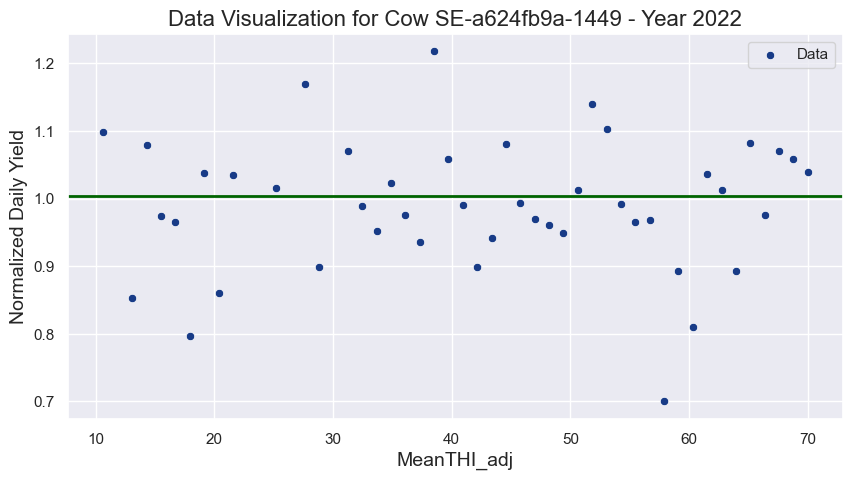

In [177]:
# Filter data for the specific farm
farm_id = 'a624fb9a'
farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm_id]

# Get unique cows (SE_Number) in the farm
unique_cows = farm_data['SE_Number'].unique()

# Initialize an empty DataFrame to store results
results_df = pd.DataFrame(columns=['FarmName_Pseudo', 'SE_Number', 'Year', 'THIMilkProduction [%]'])

# Select a random cow and a random year for plotting (you can set seed for reproducibility)
np.random.seed(42)  # For reproducibility
random_cow = np.random.choice(unique_cows)

# Get all years across the farm
all_years = farm_data['Date'].dt.year.unique()
random_year = np.random.choice(all_years)

# Iterate through each cow and year combination
for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]
    
    # Get unique years for the cow
    unique_years = cow_data['Date'].dt.year.unique()
    
    for year in unique_years:
        # Filter data for the specific year
        yearly_data = cow_data[cow_data['Date'].dt.year == year]

        # Data Preparation
        N = 50  # Number of bins
        input_feature_label = 'MeanTHI_adj'
        
        # Create bins and calculate midpoints
        bins = pd.cut(yearly_data[input_feature_label], bins=N)
        bin_midpoints = bins.apply(lambda x: x.mid)
        mean_yields = yearly_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

        # Assign target y and input vector x
        x = mean_yields[input_feature_label].values
        y = mean_yields.NormalizedDailyYield.values

        # Calculate mean_yield for this cow in this year
        mean_yield = yearly_data['NormalizedDailyYield'].mean()

        # Initial Visualization (for a random cow and year only)
        if se_number == random_cow and year == random_year:
            fig = plt.figure(figsize=(10, 5))
            ax = plt.subplot(111)
            scatter = sns.scatterplot(x=x, y=y, label='Data', color='#183B87', ax=ax)

            # Add horizontal line for the mean yield
            ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')
            
            plt.title(f"Data Visualization for Cow {se_number} - Year {year}", fontsize=16)
            plt.xlabel('MeanTHI_adj', fontsize=14)
            plt.ylabel('Normalized Daily Yield', fontsize=14)
            plt.show()


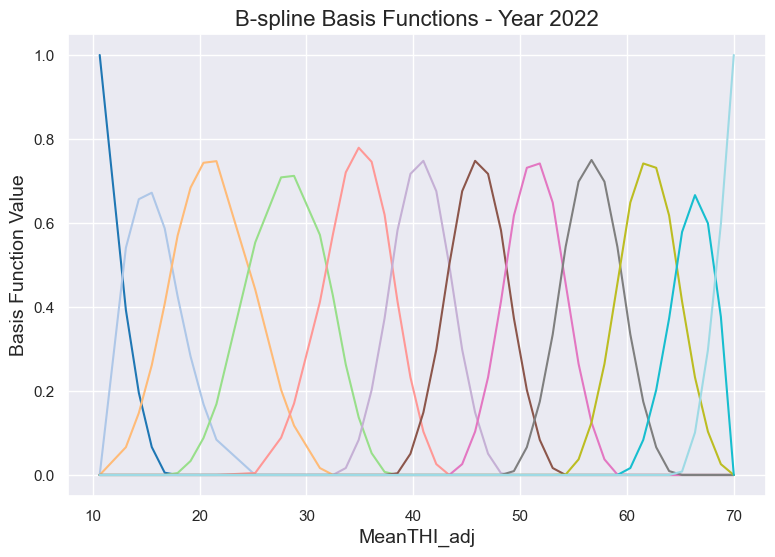

In [178]:
def Phi(a, knots, degree=3, spline_type='B'):
    lower_bound = min(a)
    upper_bound = max(a)
    
    # Adjust knots to ensure they are within the bounds
    knots = np.clip(knots, lower_bound, upper_bound)
    
    if spline_type == 'B':
        B = dmatrix(f"bs(x, knots=knots, degree={degree}, include_intercept=True) - 1", {"x": a, 'knots': knots})
    elif spline_type == 'CR':
        B = dmatrix(f"cr(x, knots=knots, constraints='center')- 1", {"x": a, 'knots': knots})
    elif spline_type == 'CC':
        B = dmatrix(f"cc(x, knots=knots, constraints='center') - 1", {"x": a, 'knots': knots})
    else:
        raise ValueError(f"{spline_type} is not a valid type, choose from 'B', 'CC' or 'CR'")
    return B


for se_number in unique_cows:
    cow_data = farm_data[farm_data['SE_Number'] == se_number]
    
    unique_years = cow_data['Date'].dt.year.unique()
    for year in unique_years:
        yearly_data = cow_data[cow_data['Date'].dt.year == year]
        
        # Create bins and calculate midpoints
        bins = pd.cut(yearly_data[input_feature_label], bins=N)
        bin_midpoints = bins.apply(lambda x: x.mid)
        mean_yields = yearly_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

        # Assign target y and input vector x
        x = mean_yields[input_feature_label].values
        y = mean_yields.NormalizedDailyYield.values

        # B-Spline Basis Functions
        degree_spline = 2
        num_qs = 10
        knot_list = np.quantile(x, q=np.linspace(0, 1, num_qs+1)[1:-1])

        B = Phi(x, knots=knot_list, degree=degree_spline, spline_type='B')

        if se_number == random_cow and year == random_year:
            color_map = plt.colormaps.get_cmap('tab20')
            colors = color_map(np.linspace(0, 1, B.shape[1]))

            fig = plt.figure(figsize=(9, 6))
            ax = plt.subplot(111)
            for i in range(B.shape[1]):
                c = colors[i]
                ax.plot(x, B[:, i], c=c, label=f'Basis {i + 1}')

            plt.title(f'B-spline Basis Functions - Year {year}', fontsize=16)
            plt.xlabel('MeanTHI_adj', fontsize=14)
            plt.ylabel('Basis Function Value', fontsize=14)
            plt.show()


Mean squared error for Cow SE-a624fb9a-1449 in Year 2022 is 0.0067


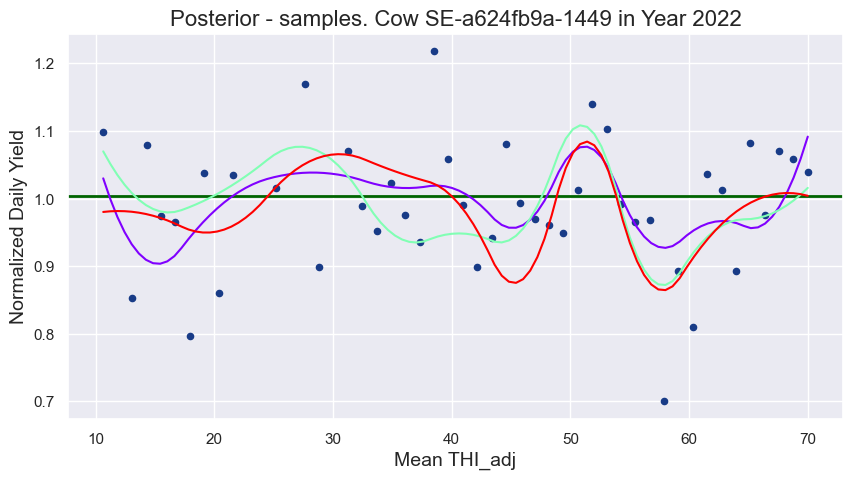

In [179]:
# Seed for reproducibility
np.random.seed(42)

# Select a random cow for plotting
random_cow = np.random.choice(unique_cows)

for se_number in unique_cows:
    cow_data = farm_data[farm_data['SE_Number'] == se_number]
    unique_years = cow_data['Date'].dt.year.unique()

    for year in unique_years:
        yearly_data = cow_data[cow_data['Date'].dt.year == year]

        # Create bins and calculate midpoints
        bins = pd.cut(yearly_data[input_feature_label], bins=N)
        bin_midpoints = bins.apply(lambda x: x.mid)
        mean_yields = yearly_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

        # Assign target y and input vector x
        x = mean_yields[input_feature_label].values
        y = mean_yields.NormalizedDailyYield.values

        if len(y) < 2:
            continue

        degree_spline = 2
        num_qs = 10
        knot_list = np.quantile(x, q=np.linspace(0, 1, num_qs + 1)[1:-1])
        B = Phi(x, knots=knot_list, degree=degree_spline, spline_type='B')

        # Block 3: Bayesian Linear Regression - GAM
        D = B.shape[1]
        m0 = np.linalg.lstsq(B, y, rcond=None)[0]
        S0 = np.cov(B.T)

        beta = 1 / np.var(y)

        SN = pinv(pinv(S0) + beta * B.T @ B)
        regularization_term = 1e-6 * np.eye(D)
        SN += regularization_term

        mN = SN @ (pinv(S0) @ m0 + beta * B.T @ y)

        mse = np.mean((y - B @ mN) ** 2)

        if se_number == random_cow and year == random_year:
            print(f"Mean squared error for Cow {se_number} in Year {year} is {mse:.4f}")
            samples = 3
            seed = 100
            ws = multivariate_normal(mean=mN, cov=SN, allow_singular=True).rvs(samples, random_state=seed)

            n = 100
            xs = np.linspace(x.min(), x.max(), n)
            new_data = {'x': xs}

            B_star = build_design_matrices([B.design_info], new_data)[0]
            B_star = np.asarray(B_star)

            fs = B_star @ ws.T

            fig = plt.figure(figsize=(10, 5))
            ax = plt.subplot(111)
            plt.scatter(x, y, color='#183B87', zorder=1, s=20)

            mean_yield = yearly_data['NormalizedDailyYield'].mean()
            ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2)

            color = cycle(cm.rainbow(np.linspace(0, 1, samples)))
            for i in range(ws.shape[0]):
                c = next(color)
                line, = ax.plot(xs, fs[:, i], c=c, label=f"Sample {i+1}")

            plt.title(f'Posterior - samples. Cow {se_number} in Year {year}', fontsize=16)
            plt.xlabel(re.sub(r'([a-z])([A-Z])', r'\1 \2', input_feature_label), fontsize=14)
            plt.ylabel('Normalized Daily Yield', fontsize=14)
            plt.show()


/var/folders/n0/fphw_xw93vv749r_ntt01qd80000gn/T/ipykernel_68699/2281615019.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_result], ignore_index=True)


Skipping Cow SE-a624fb9a-1210 for Year 2023 due to error: Incompatible dimensions (B: (9, 10))
Skipping Cow SE-a624fb9a-1264 for Year 2023 due to error: Incompatible dimensions (B: (10, 11))
Skipping Cow SE-a624fb9a-1352 for Year 2023 due to insufficient data points.
Skipping Cow SE-a624fb9a-1388 for Year 2023 due to error: Incompatible dimensions (B: (9, 10))
Skipping Cow SE-a624fb9a-1411 for Year 2024 due to error: Incompatible dimensions (B: (7, 8))
Skipping Cow SE-a624fb9a-1412 for Year 2023 due to error: Incompatible dimensions (B: (3, 4))
Skipping Cow SE-a624fb9a-1416 for Year 2023 due to insufficient data points.
Skipping Cow SE-a624fb9a-1422 for Year 2023 due to insufficient data points.


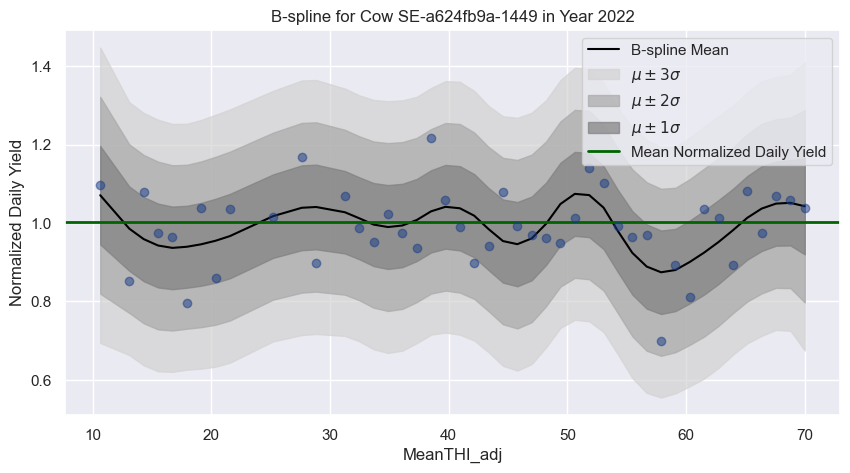

Skipping Cow SE-a624fb9a-1470 for Year 2022 due to error: Incompatible dimensions (B: (5, 6))
Skipping Cow SE-a624fb9a-1274 for Year 2023 due to error: Incompatible dimensions (B: (10, 11))


,FarmName_Pseudo,SE_Number,Year,THIMilkProduction [%],THIMilkProduction
0,a624fb9a,SE-064c0cec-1189,2022,0.692970,0.006930
1,a624fb9a,SE-30dc5787-1389,2022,4.383248,0.043832
2,a624fb9a,SE-30dc5787-1389,2023,0.508256,0.005083
3,a624fb9a,SE-30dc5787-1396,2022,-3.045213,-0.030452
4,a624fb9a,SE-30dc5787-1396,2023,2.129446,0.021294
...,...,...,...,...,...
298,a624fb9a,SE-a624fb9a-1274,2022,-1.146602,-0.011466
299,a624fb9a,SE-a624fb9a-1324,2022,-0.029706,-0.000297
300,a624fb9a,SE-a624fb9a-1428,2022,-3.293006,-0.032930
301,a624fb9a,SE-a624fb9a-1493,2023,1.073975,0.010740


In [180]:
# Seed for reproducibility
np.random.seed(42)

# Initialize an empty DataFrame to store results
results_df = pd.DataFrame(columns=['FarmName_Pseudo', 'SE_Number', 'Year', 'THIMilkProduction [%]'])

# Select a random cow for plotting
random_cow = np.random.choice(unique_cows)

for se_number in unique_cows:
    cow_data = farm_data[farm_data['SE_Number'] == se_number]
    unique_years = cow_data['Date'].dt.year.unique()

    for year in unique_years:
        yearly_data = cow_data[cow_data['Date'].dt.year == year]

        # Create bins and calculate midpoints
        bins = pd.cut(yearly_data[input_feature_label], bins=N)
        bin_midpoints = bins.apply(lambda x: x.mid)
        mean_yields = yearly_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

        # Convert bin_midpoints to numeric for comparison
        x = mean_yields[input_feature_label].values.astype(float)
        y = mean_yields.NormalizedDailyYield.values

        if len(y) < 2:
            print(f"Skipping Cow {se_number} for Year {year} due to insufficient data points.")
            continue

        try:
            # B-Spline Basis Functions (Primary Method)
            degree_spline = 2
            max_knots = min(len(y) - 1, 10)
            num_qs = max_knots
            knot_list = np.quantile(x, q=np.linspace(0, 1, num_qs + 1)[1:-1])
            B = Phi(x, knots=knot_list, degree=degree_spline, spline_type='B')

            if B.shape[0] < B.shape[1]:
                raise ValueError(f"Incompatible dimensions (B: {B.shape})")

            m0 = np.linalg.lstsq(B, y, rcond=None)[0]
            S0 = np.cov(B.T)

            beta = 1 / np.var(y)
            lambda_ridge = 0.1
            SN = np.linalg.pinv(np.linalg.pinv(S0) + beta * B.T @ B + lambda_ridge * np.eye(B.shape[1]))
            mN = SN @ (np.linalg.pinv(S0) @ m0 + beta * B.T @ y)

            mstar_mle = B @ mN
            Sstar_mle = B @ SN @ B.T + beta ** (-1) * np.eye(B.shape[0])
            stdpred_mle = np.sqrt(np.diag(Sstar_mle))

        except Exception as e:
            print(f"Skipping Cow {se_number} for Year {year} due to error: {str(e)}")
            continue

        # Integration to calculate THIMilkProduction
        above_mean = np.maximum(mstar_mle - mean_yield, 0)
        below_mean = np.maximum(mean_yield - mstar_mle, 0)

        area_above_mean = simpson(above_mean, x=x)
        area_below_mean = simpson(below_mean, x=x)

        net_area = area_above_mean - area_below_mean
        range_mean_thi = x[-1] - x[0]
        net_effect_per_unit = net_area / range_mean_thi

        net_effect_percentage = (net_effect_per_unit / mean_yield) * 100

        new_result = pd.DataFrame([{
            'FarmName_Pseudo': farm_id,
            'SE_Number': se_number,
            'Year': year,
            'THIMilkProduction [%]': net_effect_percentage
        }])

        results_df = pd.concat([results_df, new_result], ignore_index=True)

        if se_number == random_cow and year == random_year:
            fig, ax = plt.subplots(figsize=(10, 5))
            ax.plot(x, mstar_mle, 'black', label=f'B-spline Mean')
            ax.fill_between(x, mstar_mle + 3*stdpred_mle, mstar_mle - 3*stdpred_mle, color='lightgray', alpha=0.7, label=r'$\mu \pm 3\sigma$')
            ax.fill_between(x, mstar_mle + 2*stdpred_mle, mstar_mle - 2*stdpred_mle, color='darkgray', alpha=0.7, label=r'$\mu \pm 2\sigma$')
            ax.fill_between(x, mstar_mle + 1*stdpred_mle, mstar_mle - 1*stdpred_mle, color='gray', alpha=0.7, label=r'$\mu \pm 1\sigma$')
            ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')
            plt.scatter(x, y, c='#183B87', zorder=4, alpha=0.5)
            ax.legend(loc='best')
            plt.title(f'B-spline for Cow {se_number} in Year {year}')
            plt.xlabel(f'{input_feature_label}')
            plt.ylabel('Normalized Daily Yield')
            plt.show()

results_df['THIMilkProduction'] = results_df['THIMilkProduction [%]'] / 100
results_df


In [181]:
# Calculate year-to-year changes in THIMilkProduction for each cow
results_df['THIMilkProductionChange'] = results_df.groupby('SE_Number')['THIMilkProduction'].diff()

# Step 1: Remove cows with only one year of data
# Count how many years of data each cow has
cow_year_counts = results_df.groupby('SE_Number')['Year'].count()

# Filter out cows that only have one year of data
cows_with_multiple_years = cow_year_counts[cow_year_counts > 1].index
results_df = results_df[results_df['SE_Number'].isin(cows_with_multiple_years)].copy()  # Use .copy() to avoid SettingWithCopyWarning

# Step 2: Define a function to categorize the trend with stability threshold
def categorize_trend(changes, threshold=0.01):
    if all(changes > threshold):
        return 'Upward Trend'
    elif all(changes < -threshold):
        return 'Downward Trend'
    elif all((changes >= -threshold) & (changes <= threshold)):
        return 'Stable Trend'
    else:
        return 'Mixed Trend'

# Step 3: Apply categorization to cows with two years and assign the same category to both rows
def categorize_for_two_years(changes, threshold=0.01):
    if len(changes) == 2:
        category = categorize_trend(changes, threshold)
        return pd.Series([category, category], index=changes.index)  # Return a Series with the same category for both years
    else:
        return pd.Series([categorize_trend(changes.dropna(), threshold)] * len(changes), index=changes.index)  # Handle cases with more than two years

# Step 4: Calculate year-to-year changes and apply the categorization
results_df['THIMilkProductionChange'] = results_df.groupby('SE_Number')['THIMilkProduction'].diff()

# Apply the trend categorization for cows with two years of data
trend_categories = results_df.groupby('SE_Number')['THIMilkProductionChange'].apply(lambda x: categorize_for_two_years(x, threshold=0.01))

# Step 5: Reset the index of the `trend_categories` to align with the `results_df` index
trend_categories = trend_categories.reset_index(level=0, drop=True)

# Assign the categories back to the original DataFrame
results_df['TrendCategory'] = trend_categories

# Step 6: Check the result
results_df[['SE_Number', 'Year', 'THIMilkProduction', 'THIMilkProductionChange', 'TrendCategory']]


,SE_Number,Year,THIMilkProduction,THIMilkProductionChange,TrendCategory
1,SE-30dc5787-1389,2022,0.043832,NaN,Mixed Trend
2,SE-30dc5787-1389,2023,0.005083,-0.038750,Mixed Trend
3,SE-30dc5787-1396,2022,-0.030452,NaN,Mixed Trend
4,SE-30dc5787-1396,2023,0.021294,0.051747,Mixed Trend
6,SE-a624fb9a-1162,2022,0.042715,NaN,Mixed Trend
...,...,...,...,...,...
293,SE-a624fb9a-1515,2024,-0.007196,-0.022979,Mixed Trend
294,SE-a624fb9a-1516,2023,-0.012959,NaN,Mixed Trend
295,SE-a624fb9a-1516,2024,0.003363,0.016321,Mixed Trend
301,SE-a624fb9a-1493,2023,0.010740,NaN,Mixed Trend


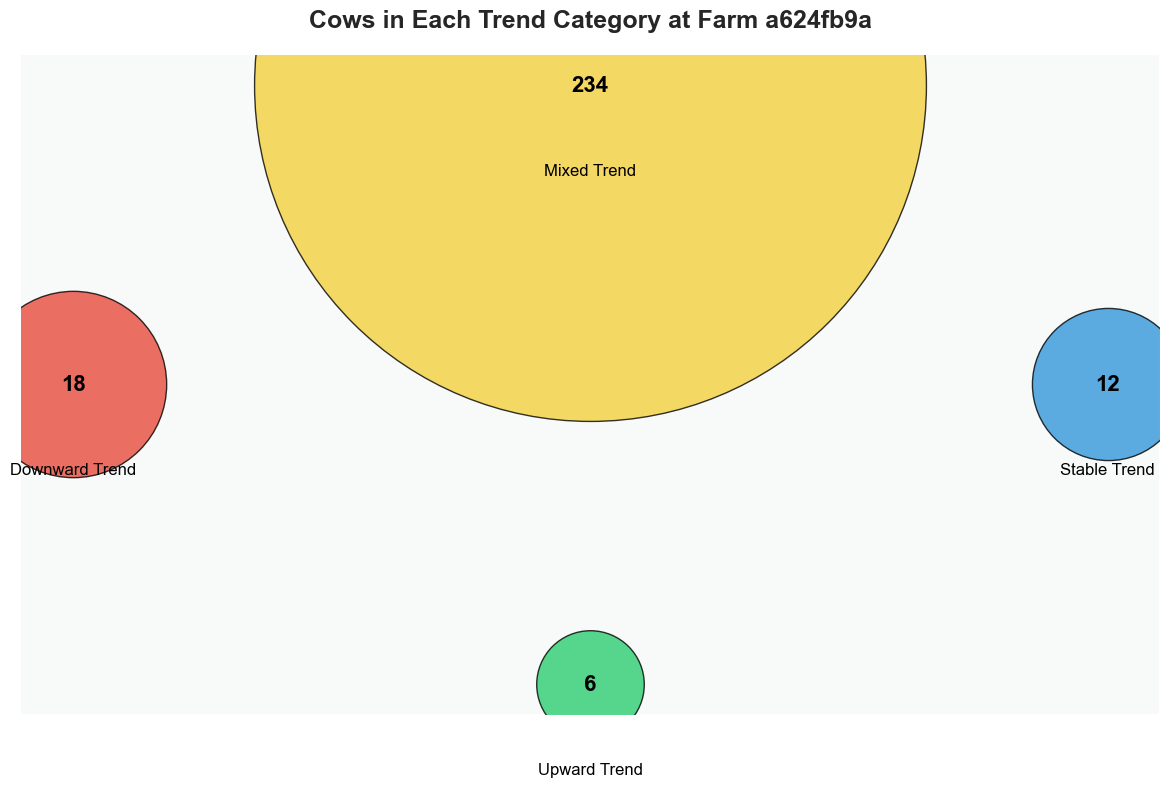

In [182]:
# Step 1: Count the number of cows in each trend category
category_counts = results_df['TrendCategory'].value_counts()

# Step 2: Set up the positions for the diamond layout (4 positions)
x_positions = np.array([0, -1, 1, 0])  # X positions for the diamond layout
y_positions = np.array([2, 1, 1, 0])  # Y positions to create a diamond shape

# Step 3: Create a modern bubble plot
plt.figure(figsize=(12, 8))

# Define a modern color palette for the bubbles
colors = {
    'Upward Trend': '#2ECC71',      # Soft green
    'Downward Trend': '#E74C3C',    # Soft red
    'Stable Trend': '#3498DB',      # Soft blue
    'Mixed Trend': '#F4D03F'        # Soft yellow
}

# Plot each category as a bubble in a diamond shape
for i, (category, count) in enumerate(category_counts.items()):
    plt.scatter(x_positions[i], y_positions[i], s=count * 1000, c=colors[category], edgecolors='black', alpha=0.8)
    plt.text(x_positions[i], y_positions[i], str(count), fontsize=16, ha='center', va='center', fontweight='bold', color='black')

# Step 4: Customize the plot for a modern look
plt.xticks([])  # Remove x-ticks
plt.yticks([])  # Remove y-ticks
plt.gca().set_facecolor('#F8F9F9')  # Light background
plt.title(f'Cows in Each Trend Category at Farm {farm_id}', fontsize=18, pad=20, weight='bold')

# Remove unnecessary plot borders for a cleaner look
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

# Add annotations for each bubble (category name)
for i, category in enumerate(category_counts.index):
    plt.text(x_positions[i], y_positions[i] - 0.3, category, fontsize=12, ha='center', color='black')

# Step 5: Show the plot
plt.tight_layout()
plt.show()

# Farm 5c06d92d

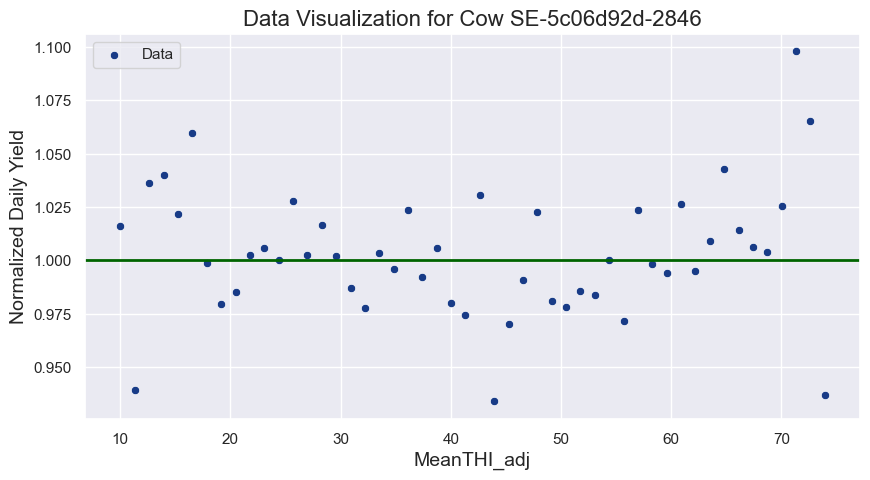

In [183]:
# Filter data for the specific farm
farm_id = '5c06d92d'
farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm_id]

# Get unique cows (SE_Number) in the farm
unique_cows = farm_data['SE_Number'].unique()

# Select a random cow for plotting (you can set seed for reproducibility)
np.random.seed(42)  # For reproducibility
random_cow = np.random.choice(unique_cows)

for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]

    # Data Preparation
    N = 50  # Number of bins
    input_feature_label = 'MeanTHI_adj'
    
    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N) 
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Assign target y and input vector x
    x = mean_yields[input_feature_label].values
    y = mean_yields.NormalizedDailyYield.values

    # Calculate mean_yield for this cow
    mean_yield = cow_data['NormalizedDailyYield'].mean()

    # Initial Visualization (for a random cow only)
    if se_number == random_cow:
        fig = plt.figure(figsize=(10, 5))
        ax = plt.subplot(111)
        scatter = sns.scatterplot(x=x, y=y, label='Data', color='#183B87', ax=ax)

        # Add horizontal line for the mean yield
        mean_yield = cow_data['NormalizedDailyYield'].mean()
        ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')
        
        plt.title(f"Data Visualization for Cow {se_number}", fontsize=16)
        plt.xlabel('MeanTHI_adj', fontsize=14)
        plt.ylabel('Normalized Daily Yield', fontsize=14)
        plt.show()

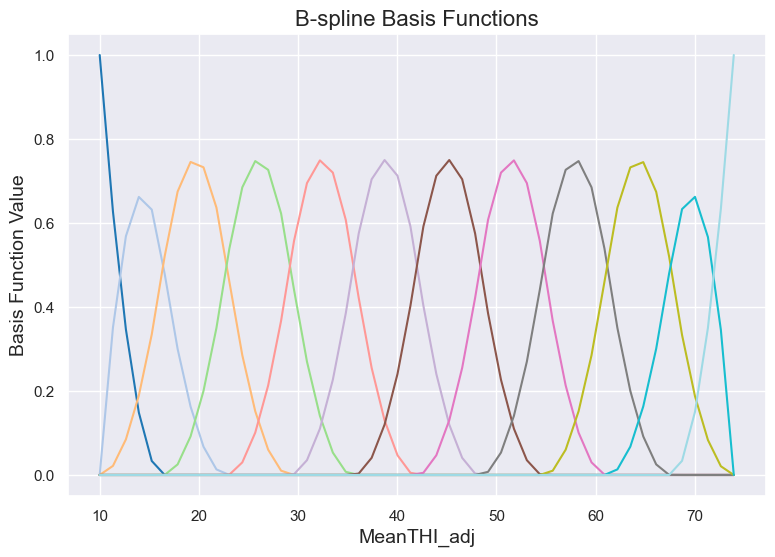

In [184]:
def Phi(a, knots, degree=3, spline_type='B'):
    lower_bound = min(a)
    upper_bound = max(a)
    
    # Adjust knots to ensure they are within the bounds
    knots = np.clip(knots, lower_bound, upper_bound)
    
    if spline_type == 'B':
        B = dmatrix(f"bs(x, knots=knots, degree={degree}, include_intercept=True) - 1", {"x": a, 'knots': knots})
    elif spline_type == 'CR':
        B = dmatrix(f"cr(x, knots=knots, constraints='center')- 1", {"x": a, 'knots': knots})
    elif spline_type == 'CC':
        B = dmatrix(f"cc(x, knots=knots, constraints='center') - 1", {"x": a, 'knots': knots})
    else:
        raise ValueError(f"{spline_type} is not a valid type, choose from 'B', 'CC' or 'CR'")
    return B


for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]
    
    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N) 
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Assign target y and input vector x
    x = mean_yields[input_feature_label].values
    y = mean_yields.NormalizedDailyYield.values

    # Block 2: B-Spline Basis Functions
    degree_spline = 2  # Change the order of the polynomial here
    num_qs = 10
    knot_list = np.quantile(x, q=np.linspace(0, 1, num_qs+1)[1:-1])

    B = Phi(x, knots=knot_list, degree=degree_spline, spline_type='B')

    # Plot Basis Functions (for the random cow)
    if se_number == random_cow:
        color_map = plt.colormaps.get_cmap('tab20')
        colors = color_map(np.linspace(0, 1, B.shape[1]))

        fig = plt.figure(figsize=(9, 6))
        ax = plt.subplot(111)
        for i in range(B.shape[1]):
            c = colors[i]
            ax.plot(x, B[:, i], c=c, label=f'Basis {i + 1}')

        plt.title('B-spline Basis Functions', fontsize=16)
        plt.xlabel('MeanTHI_adj', fontsize=14)
        plt.ylabel('Basis Function Value', fontsize=14)
        plt.show()

Mean squared error for Cow SE-5c06d92d-2846 is 0.0007


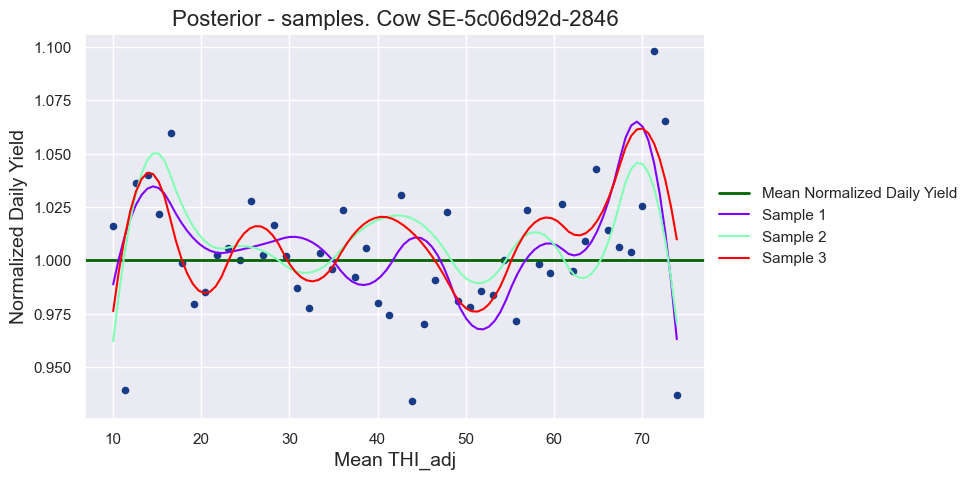

KeyboardInterrupt: 

In [185]:
# Seed for reproducibility
np.random.seed(42)

# Select a random cow for plotting
random_cow = np.random.choice(unique_cows)

for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]

    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N)
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Assign target y and input vector x
    x = mean_yields[input_feature_label].values
    y = mean_yields.NormalizedDailyYield.values

    # Check if there are enough data points
    if len(y) < 2:  # If fewer than 2 data points, skip this cow
        print(f"Skipping Cow {se_number} due to insufficient data points.")
        continue

    # Block 2: B-Spline Basis Functions
    degree_spline = 2  # Change the order of the polynomial here
    num_qs = 10
    knot_list = np.quantile(x, q=np.linspace(0, 1, num_qs + 1)[1:-1])

    B = Phi(x, knots=knot_list, degree=degree_spline, spline_type='B')

    # Block 3: Bayesian Linear Regression - GAM
    # Calculate empirical priors from the data
    D = B.shape[1]
    m0 = np.linalg.lstsq(B, y, rcond=None)[0]  # Least-squares estimate as prior mean
    S0 = np.cov(B.T)  # Covariance of the design matrix as prior covariance

    if np.any(np.isnan(S0)) or np.any(np.isinf(S0)):
        print(f"Skipping Cow {se_number} due to invalid covariance matrix.")
        continue

    beta = 1 / np.var(y)

    if np.isinf(beta) or np.isnan(beta):
        print(f"Skipping Cow {se_number} due to invalid beta value.")
        continue

    # Compute the posterior distribution with new priors
    SN = pinv(pinv(S0) + beta * B.T @ B)

    # Adding a small regularization term to ensure positive semi-definiteness
    regularization_term = 1e-6 * np.eye(D)
    SN += regularization_term

    mN = SN @ (pinv(S0) @ m0 + beta * B.T @ y)

    # Print MSE for this cow
    mse = np.mean((y - B @ mN) ** 2)

    # Plot the posterior for the random cow
    if se_number == random_cow:
        print(f"Mean squared error for Cow {se_number} is {mse:.4f}")
        samples = 3
        seed = 100
        ws = multivariate_normal(mean=mN, cov=SN, allow_singular=True).rvs(samples, random_state=seed)

        n = 100  # number of grid-points
        xs = np.linspace(x.min(), x.max(), n)
        new_data = {'x': xs}

        B_star = build_design_matrices([B.design_info], new_data)[0]
        B_star = np.asarray(B_star)

        # Compute corresponding values f(x*)
        fs = B_star @ ws.T

        # Plot the samples
        fig = plt.figure(figsize=(10, 5))
        ax = plt.subplot(111)
        plt.scatter(x, y, color='#183B87', zorder=1, s=20)

        # Add horizontal line for the mean yield
        mean_yield = cow_data['NormalizedDailyYield'].mean()
        ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')

        color = cycle(cm.rainbow(np.linspace(0, 1, samples)))
        for i in range(ws.shape[0]):
            c = next(color)
            line, = ax.plot(xs, fs[:, i], c=c, label=f"Sample {i+1}")

        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), framealpha=0)  # Set legend transparency

        plt.title(f'Posterior - samples. Cow {se_number}', fontsize=16)
        plt.xlabel(re.sub(r'([a-z])([A-Z])', r'\1 \2', input_feature_label), fontsize=14)
        plt.ylabel('Normalized Daily Yield', fontsize=14)  # Updated ylabel

        plt.show()

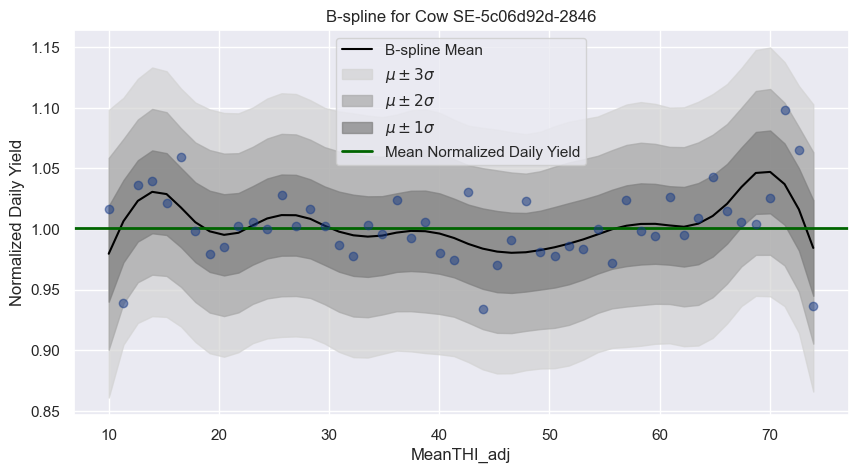

,FarmName_Pseudo,SE_Number,THIMilkProduction [%],THIMilkProduction
0,5c06d92d,SE-5c06d92d-2055,0.490749,0.004907
1,5c06d92d,SE-5c06d92d-2058,1.542894,0.015429
2,5c06d92d,SE-5c06d92d-2254,-3.587441,-0.035874
3,5c06d92d,SE-5c06d92d-2283,5.222700,0.052227
4,5c06d92d,SE-5c06d92d-2333,-0.522059,-0.005221
...,...,...,...,...
473,5c06d92d,SE-5c06d92d-3441,0.663291,0.006633
474,5c06d92d,SE-5c06d92d-3443,0.029874,0.000299
475,5c06d92d,SE-5c06d92d-3485,2.090594,0.020906
476,5c06d92d,SE-5c06d92d-3511,-0.105135,-0.001051


In [171]:
# Seed for reproducibility
np.random.seed(42)

# Initialize an empty DataFrame to store results
results_df = pd.DataFrame(columns=['FarmName_Pseudo', 'SE_Number', 'THIMilkProduction [%]'])

# Select a random cow for plotting
random_cow = np.random.choice(unique_cows)

for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]

    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N)
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Convert bin_midpoints to numeric for comparison
    x = mean_yields[input_feature_label].values.astype(float)
    y = mean_yields.NormalizedDailyYield.values

    # Ensure sufficient data points
    if len(y) < 2:  # Ensure at least 2 data points
        print(f"Skipping Cow {se_number} due to insufficient data points.")
        continue

    try:
        # B-Spline Basis Functions (Primary Method)
        degree_spline = 2  # Change the order of the polynomial here
        max_knots = min(len(y) - 1, 10)
        num_qs = max_knots
        knot_list = np.quantile(x, q=np.linspace(0, 1, num_qs + 1)[1:-1])
        B = Phi(x, knots=knot_list, degree=degree_spline, spline_type='B')

        # Check if B has more rows than columns
        if B.shape[0] < B.shape[1]:
            raise ValueError(f"Incompatible dimensions (B: {B.shape})")

        # Step 1: Calculate empirical priors from the correct data
        m0 = np.linalg.lstsq(B, y, rcond=None)[0]  # Least-squares estimate as prior mean
        S0 = np.cov(B.T)  # Covariance of the design matrix as prior covariance

        if np.any(np.isnan(S0)) or np.any(np.isinf(S0)):
            print(f"Skipping Cow {se_number} due to invalid covariance matrix.")
            continue

        # Bayesian Linear Regression
        beta = 1 / np.var(y)
        lambda_ridge = 0.1
        SN = np.linalg.pinv(np.linalg.pinv(S0) + beta * B.T @ B + lambda_ridge * np.eye(B.shape[1]))
        mN = SN @ (np.linalg.pinv(S0) @ m0 + beta * B.T @ y)

        # Make predictions
        mstar_mle = B @ mN
        Sstar_mle = B @ SN @ B.T + beta ** (-1) * np.eye(B.shape[0])
        stdpred_mle = np.sqrt(np.diag(Sstar_mle))
        model_type = 'B-spline'

    except Exception as e:
        print(f"Skipping Cow {se_number} due to incompatible dimensions or another error: {str(e)}")
        continue

    # Filter x and corresponding mstar_mle for values >= 61
    filtered_indices = x >= 61  # Only include THI values >= 61
    if np.sum(filtered_indices) < 2:
        print(f"Skipping Cow {se_number} due to insufficient data points after filtering.")
        continue

    filtered_xs = x[filtered_indices]
    filtered_mstar_mle = mstar_mle[filtered_indices]

    # Integration to calculate THIMilkProduction
    above_mean = np.maximum(filtered_mstar_mle - mean_yield, 0)
    below_mean = np.maximum(mean_yield - filtered_mstar_mle, 0)

    # Integrate over the filtered x values
    area_above_mean = simpson(above_mean, x=filtered_xs)
    area_below_mean = simpson(below_mean, x=filtered_xs)

    # Calculate the net area (above - below)
    net_area = area_above_mean - area_below_mean
    range_mean_temperature = filtered_xs[-1] - filtered_xs[0]
    net_effect_per_unit = net_area / range_mean_temperature

    # Express the net effect as a percentage of the mean yield
    net_effect_percentage = (net_effect_per_unit / mean_yield) * 100

    # Store results in the DataFrame
    new_result = pd.DataFrame([{
        'FarmName_Pseudo': farm_id,
        'SE_Number': se_number,
        'THIMilkProduction [%]': net_effect_percentage
    }])

    if results_df.empty:
        results_df = new_result
    else:
        results_df = pd.concat([results_df, new_result], ignore_index=True)

    # Plot for the randomly selected cow
    if se_number == random_cow:
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot(x, mstar_mle, 'black', label=f'{model_type} Mean')
        ax.fill_between(x, mstar_mle + 3*stdpred_mle, mstar_mle - 3*stdpred_mle, color='lightgray', alpha=0.7, label=r'$\mu \pm 3\sigma$')
        ax.fill_between(x, mstar_mle + 2*stdpred_mle, mstar_mle - 2*stdpred_mle, color='darkgray', alpha=0.7, label=r'$\mu \pm 2\sigma$')
        ax.fill_between(x, mstar_mle + 1*stdpred_mle, mstar_mle - 1*stdpred_mle, color='gray', alpha=0.7, label=r'$\mu \pm 1\sigma$')
        ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')
        plt.scatter(x, y, c='#183B87', zorder=4, alpha=0.5)
        ax.legend(loc='best')
        plt.title(f'{model_type} for Cow {se_number}')
        plt.xlabel(f'{input_feature_label}')
        plt.ylabel('Normalized Daily Yield')
        plt.show()

# Display the results
results_df['THIMilkProduction'] = results_df['THIMilkProduction [%]'] / 100
results_df

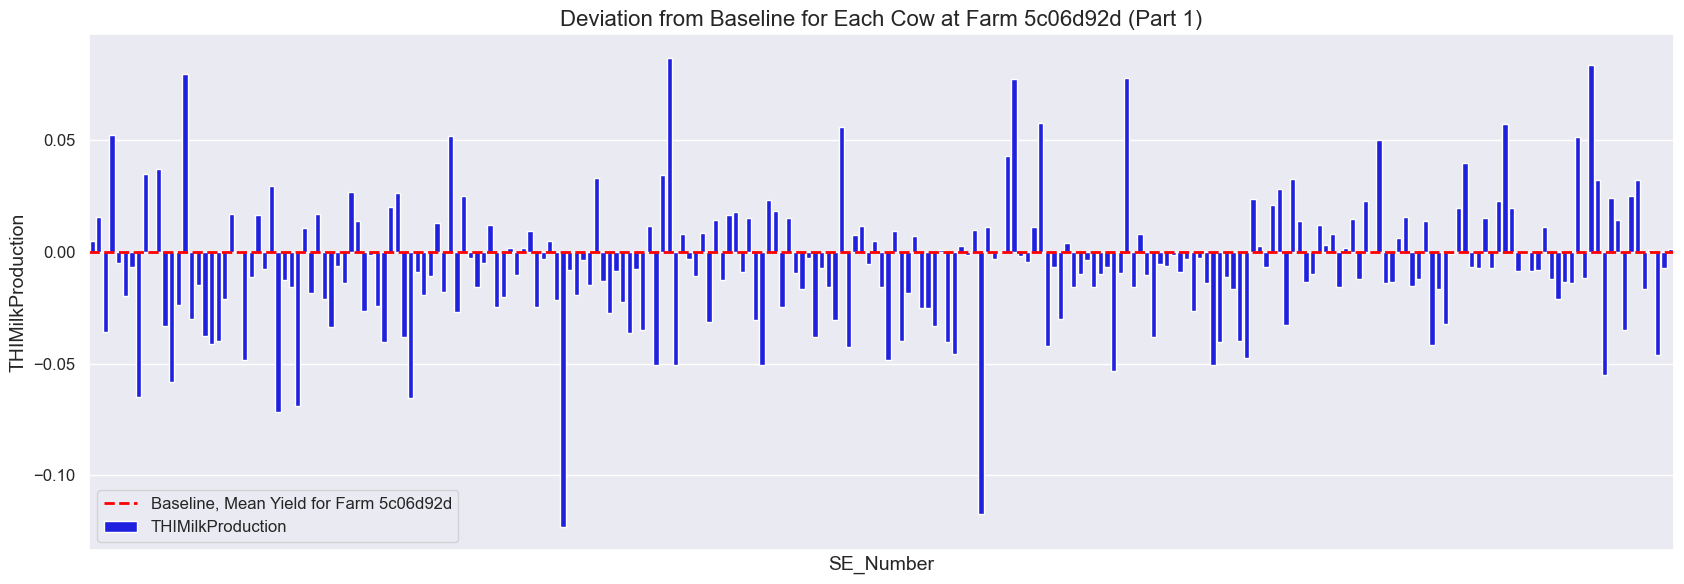

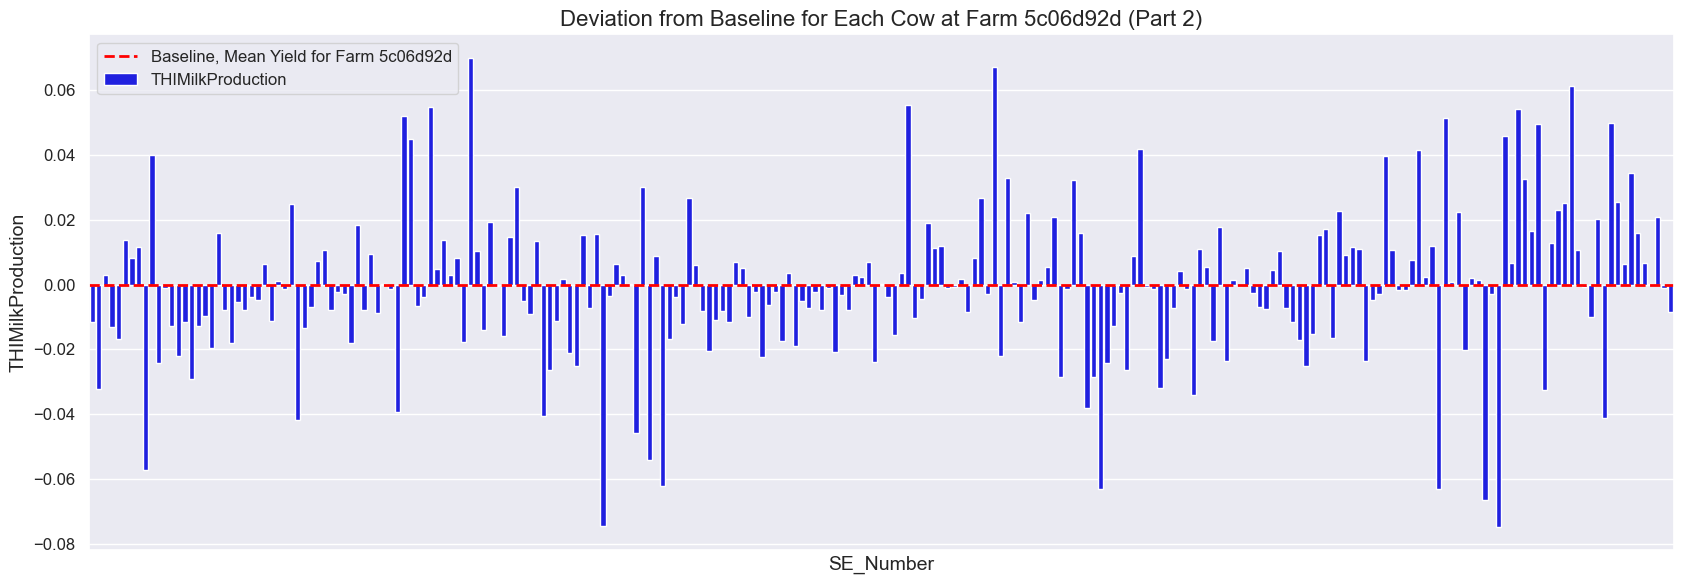

In [172]:
# Calculate the midpoint to split the data into two halves
midpoint = len(results_df) // 2

# Split the data into two halves
first_half = results_df.iloc[:midpoint]
second_half = results_df.iloc[midpoint:]

# Plotting for the first half
plt.figure(figsize=(17, 6))
sns.barplot(x=first_half.index, y=first_half['THIMilkProduction'], color='blue', label='THIMilkProduction')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline, Mean Yield for Farm {farm_id}')
plt.xlabel('SE_Number', fontsize=14)
plt.ylabel('THIMilkProduction', fontsize=14)
plt.title(f'Deviation from Baseline for Each Cow at Farm {farm_id} (Part 1)', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# Plotting for the second half
plt.figure(figsize=(17, 6))
sns.barplot(x=second_half.index, y=second_half['THIMilkProduction'], color='blue', label='THIMilkProduction')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline, Mean Yield for Farm {farm_id}')
plt.xlabel('SE_Number', fontsize=14)
plt.ylabel('THIMilkProduction', fontsize=14)
plt.title(f'Deviation from Baseline for Each Cow at Farm {farm_id} (Part 2)', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

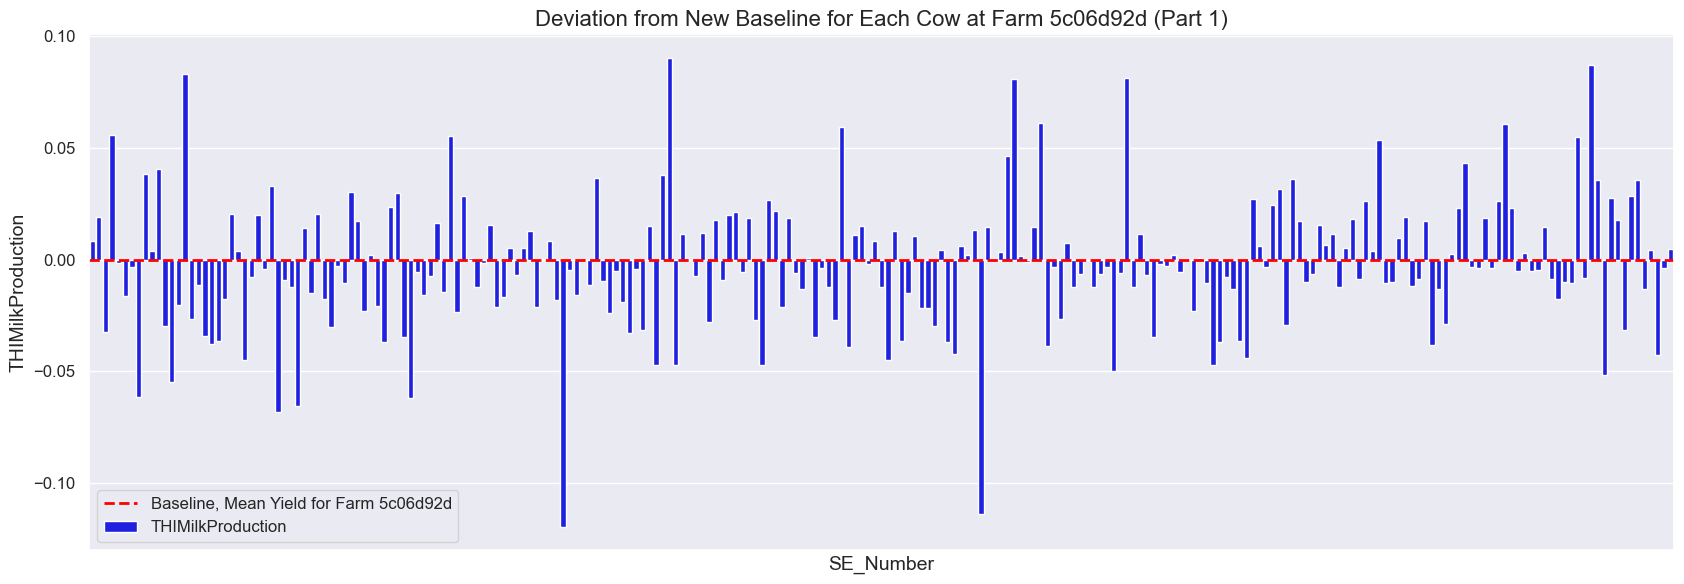

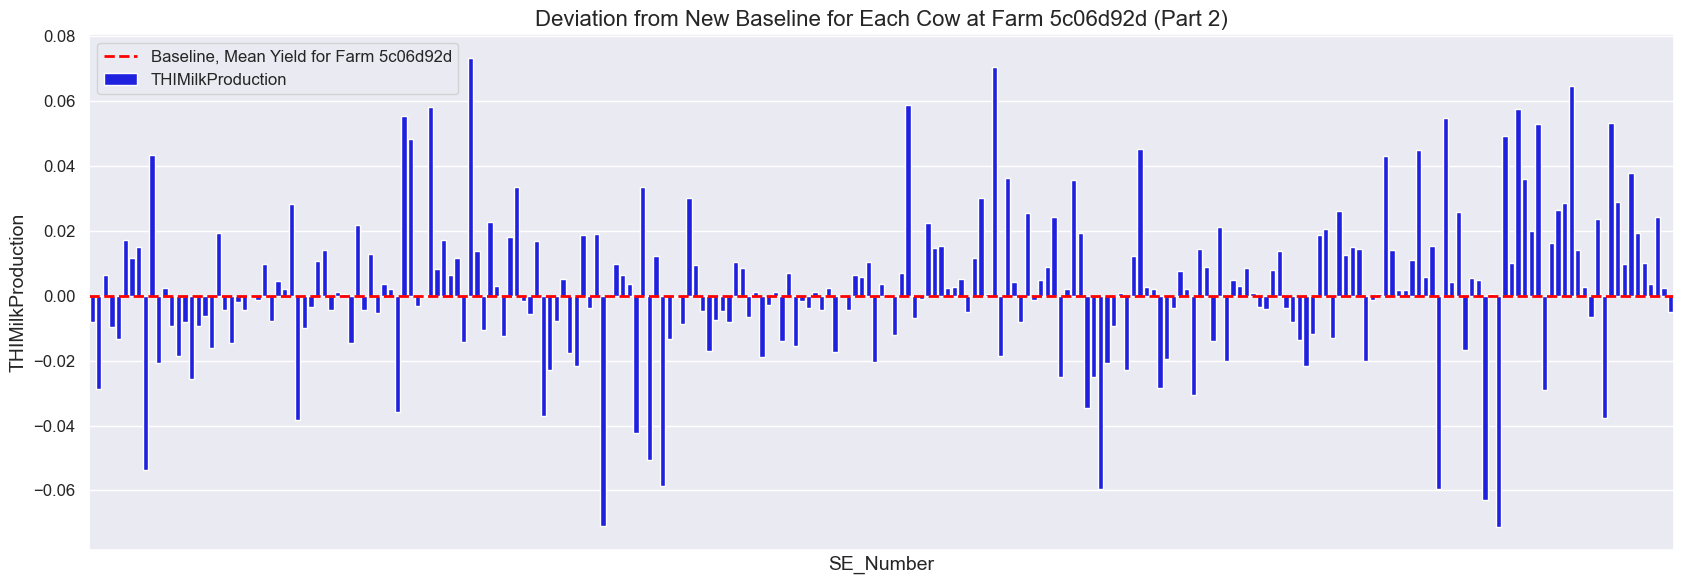

In [173]:
# New baseline value
new_baseline = results_df['THIMilkProduction'].mean()

# Adjust the THIMilkProduction to start from the new baseline
results_df['AdjustedTHIMilkProduction'] = results_df['THIMilkProduction'] - new_baseline

# Calculate the midpoint to split the data into two halves
midpoint = len(results_df) // 2

# Split the data into two halves
first_half = results_df.iloc[:midpoint]
second_half = results_df.iloc[midpoint:]

# Plotting for the first half
plt.figure(figsize=(17, 6))
sns.barplot(x=first_half.index, y=first_half['AdjustedTHIMilkProduction'], color='blue', label='THIMilkProduction')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline, Mean Yield for Farm {farm_id}')
plt.xlabel('SE_Number', fontsize=14)
plt.ylabel('THIMilkProduction', fontsize=14)
plt.title(f'Deviation from New Baseline for Each Cow at Farm {farm_id} (Part 1)', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# Plotting for the second half
plt.figure(figsize=(17, 6))
sns.barplot(x=second_half.index, y=second_half['AdjustedTHIMilkProduction'], color='blue', label='THIMilkProduction')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline, Mean Yield for Farm {farm_id}')
plt.xlabel('SE_Number', fontsize=14)
plt.ylabel('THIMilkProduction', fontsize=14)
plt.title(f'Deviation from New Baseline for Each Cow at Farm {farm_id} (Part 2)', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

## Farm 752efd72

In [174]:
# Filter data for the specific farm
farm_id = '752efd72'
farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm_id]

# Get unique cows (SE_Number) in the farm
unique_cows = farm_data['SE_Number'].unique()

# Initialize an empty DataFrame to store results
results_df = pd.DataFrame(columns=['FarmName_Pseudo', 'SE_Number', 'CumHeatLoadMilkProduction [%]'])

# Select a random cow for plotting (you can set seed for reproducibility)
np.random.seed(42)  # For reproducibility
random_cow = np.random.choice(unique_cows)

for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]

    # Data Preparation
    N = 50  # Number of bins
    input_feature_label = 'MeanTHI_adj'
    
    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N) 
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Assign target y and input vector x
    x = mean_yields[input_feature_label].values
    y = mean_yields.NormalizedDailyYield.values

    # Calculate mean_yield for this cow
    mean_yield = cow_data['NormalizedDailyYield'].mean()

    # Initial Visualization (for a random cow only)
    if se_number == random_cow:
        fig = plt.figure(figsize=(10, 5))
        ax = plt.subplot(111)
        scatter = sns.scatterplot(x=x, y=y, label='Data', color='#183B87', ax=ax)

        # Add horizontal line for the mean yield
        mean_yield = cow_data['NormalizedDailyYield'].mean()
        ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')
        
        plt.title(f"Data Visualization for Cow {se_number}", fontsize=16)
        plt.xlabel('MeanTHI_adj', fontsize=14)
        plt.ylabel('Normalized Daily Yield', fontsize=14)
        plt.show()

KeyboardInterrupt: 

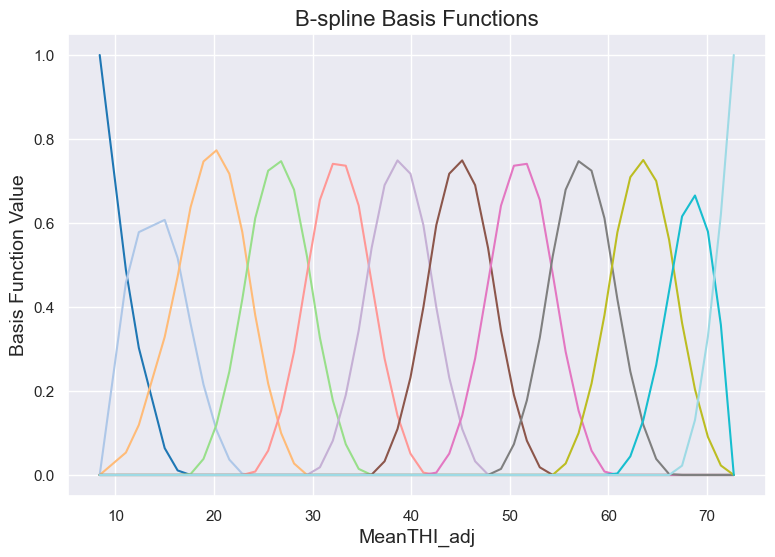

KeyboardInterrupt: 

In [82]:
def Phi(a, knots, degree=3, spline_type='B'):
    lower_bound = min(a)
    upper_bound = max(a)
    
    # Adjust knots to ensure they are within the bounds
    knots = np.clip(knots, lower_bound, upper_bound)
    
    if spline_type == 'B':
        B = dmatrix(f"bs(x, knots=knots, degree={degree}, include_intercept=True) - 1", {"x": a, 'knots': knots})
    elif spline_type == 'CR':
        B = dmatrix(f"cr(x, knots=knots, constraints='center')- 1", {"x": a, 'knots': knots})
    elif spline_type == 'CC':
        B = dmatrix(f"cc(x, knots=knots, constraints='center') - 1", {"x": a, 'knots': knots})
    else:
        raise ValueError(f"{spline_type} is not a valid type, choose from 'B', 'CC' or 'CR'")
    return B


for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]
    
    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N) 
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Assign target y and input vector x
    x = mean_yields[input_feature_label].values
    y = mean_yields.NormalizedDailyYield.values

    # Block 2: B-Spline Basis Functions
    degree_spline = 2  # Change the order of the polynomial here
    num_qs = 10
    knot_list = np.quantile(x, q=np.linspace(0, 1, num_qs+1)[1:-1])

    B = Phi(x, knots=knot_list, degree=degree_spline, spline_type='B')

    # Plot Basis Functions (for the random cow)
    if se_number == random_cow:
        color_map = plt.colormaps.get_cmap('tab20')
        colors = color_map(np.linspace(0, 1, B.shape[1]))

        fig = plt.figure(figsize=(9, 6))
        ax = plt.subplot(111)
        for i in range(B.shape[1]):
            c = colors[i]
            ax.plot(x, B[:, i], c=c, label=f'Basis {i + 1}')

        plt.title('B-spline Basis Functions', fontsize=16)
        plt.xlabel('MeanTHI_adj', fontsize=14)
        plt.ylabel('Basis Function Value', fontsize=14)
        plt.show()

Mean squared error for Cow SE-752efd72-0222 is 0.0034


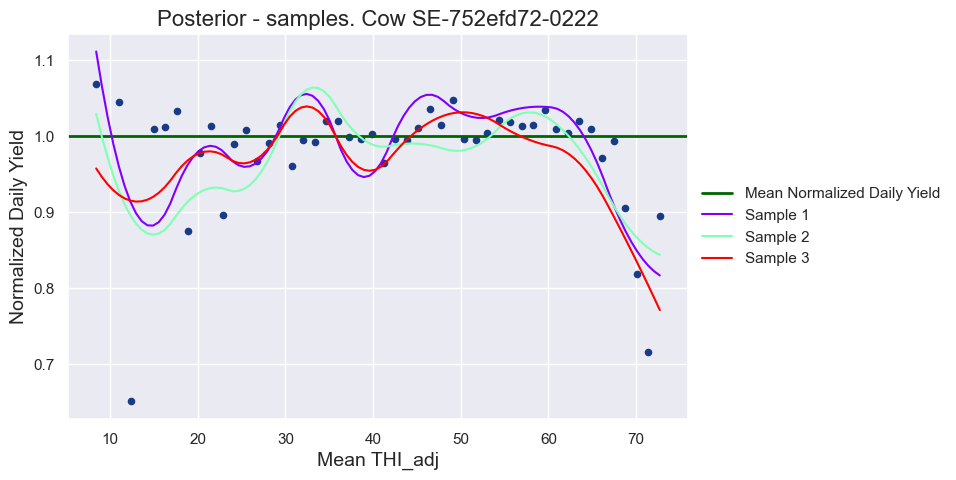

In [15]:
# Seed for reproducibility
np.random.seed(42)

# Select a random cow for plotting
random_cow = np.random.choice(unique_cows)

for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]

    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N)
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Assign target y and input vector x
    x = mean_yields[input_feature_label].values
    y = mean_yields.NormalizedDailyYield.values

    # Check if there are enough data points
    if len(y) < 2:  # If fewer than 2 data points, skip this cow
        print(f"Skipping Cow {se_number} due to insufficient data points.")
        continue

    # Block 2: B-Spline Basis Functions
    degree_spline = 2  # Change the order of the polynomial here
    num_qs = 10
    knot_list = np.quantile(x, q=np.linspace(0, 1, num_qs + 1)[1:-1])

    B = Phi(x, knots=knot_list, degree=degree_spline, spline_type='B')

    # Block 3: Bayesian Linear Regression - GAM
    # Calculate empirical priors from the data
    D = B.shape[1]
    m0 = np.linalg.lstsq(B, y, rcond=None)[0]  # Least-squares estimate as prior mean
    S0 = np.cov(B.T)  # Covariance of the design matrix as prior covariance

    if np.any(np.isnan(S0)) or np.any(np.isinf(S0)):
        print(f"Skipping Cow {se_number} due to invalid covariance matrix.")
        continue

    beta = 1 / np.var(y)

    if np.isinf(beta) or np.isnan(beta):
        print(f"Skipping Cow {se_number} due to invalid beta value.")
        continue

    # Compute the posterior distribution with new priors
    SN = pinv(pinv(S0) + beta * B.T @ B)

    # Adding a small regularization term to ensure positive semi-definiteness
    regularization_term = 1e-6 * np.eye(D)
    SN += regularization_term

    mN = SN @ (pinv(S0) @ m0 + beta * B.T @ y)

    # Print MSE for this cow
    mse = np.mean((y - B @ mN) ** 2)

    # Plot the posterior for the random cow
    if se_number == random_cow:
        print(f"Mean squared error for Cow {se_number} is {mse:.4f}")
        samples = 3
        seed = 100
        ws = multivariate_normal(mean=mN, cov=SN, allow_singular=True).rvs(samples, random_state=seed)

        n = 100  # number of grid-points
        xs = np.linspace(x.min(), x.max(), n)
        new_data = {'x': xs}

        B_star = build_design_matrices([B.design_info], new_data)[0]
        B_star = np.asarray(B_star)

        # Compute corresponding values f(x*)
        fs = B_star @ ws.T

        # Plot the samples
        fig = plt.figure(figsize=(10, 5))
        ax = plt.subplot(111)
        plt.scatter(x, y, color='#183B87', zorder=1, s=20)

        # Add horizontal line for the mean yield
        mean_yield = cow_data['NormalizedDailyYield'].mean()
        ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')

        color = cycle(cm.rainbow(np.linspace(0, 1, samples)))
        for i in range(ws.shape[0]):
            c = next(color)
            line, = ax.plot(xs, fs[:, i], c=c, label=f"Sample {i+1}")

        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), framealpha=0)  # Set legend transparency

        plt.title(f'Posterior - samples. Cow {se_number}', fontsize=16)
        plt.xlabel(re.sub(r'([a-z])([A-Z])', r'\1 \2', input_feature_label), fontsize=14)
        plt.ylabel('Normalized Daily Yield', fontsize=14)  # Updated ylabel

        plt.show()

Skipping Cow SE-752efd72-0093 due to insufficient data points after filtering.


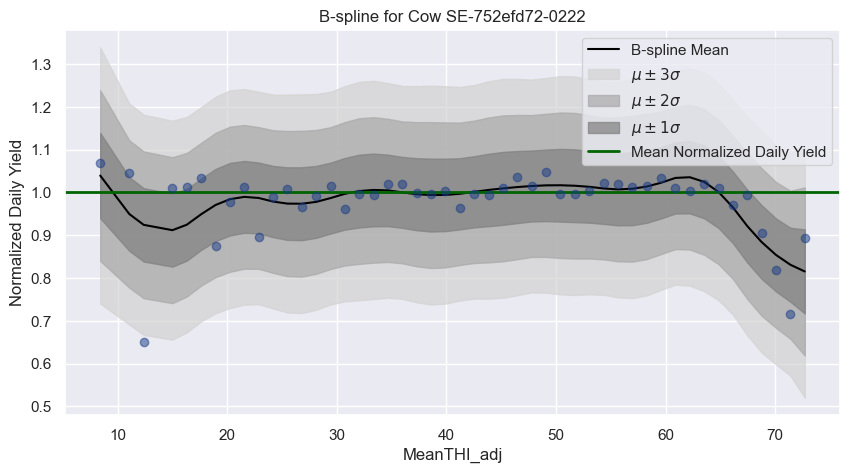

Skipping Cow SE-752efd72-2795 due to insufficient data points after filtering.


,FarmName_Pseudo,SE_Number,THIMilkProduction [%],THIMilkProduction
0,752efd72,SE-752efd72-0001,-3.366610,-0.033666
1,752efd72,SE-752efd72-0002,7.096095,0.070961
2,752efd72,SE-752efd72-0008,-0.626645,-0.006266
3,752efd72,SE-752efd72-0010,-2.743902,-0.027439
4,752efd72,SE-752efd72-0011,-1.993399,-0.019934
...,...,...,...,...
396,752efd72,SE-752efd72-0345,-2.447161,-0.024472
397,752efd72,SE-752efd72-0450,-0.826783,-0.008268
398,752efd72,SE-752efd72-0468,-0.652259,-0.006523
399,752efd72,SE-752efd72-0469,-0.815849,-0.008158


In [16]:
# Seed for reproducibility
np.random.seed(42)

# Initialize an empty DataFrame to store results
results_df = pd.DataFrame(columns=['FarmName_Pseudo', 'SE_Number', 'THIMilkProduction [%]'])

# Select a random cow for plotting
random_cow = np.random.choice(unique_cows)

for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]

    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N)
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Convert bin_midpoints to numeric for comparison
    x = mean_yields[input_feature_label].values.astype(float)
    y = mean_yields.NormalizedDailyYield.values

    # Ensure sufficient data points
    if len(y) < 2:  # Ensure at least 2 data points
        print(f"Skipping Cow {se_number} due to insufficient data points.")
        continue

    try:
        # B-Spline Basis Functions (Primary Method)
        degree_spline = 2  # Change the order of the polynomial here
        max_knots = min(len(y) - 1, 10)
        num_qs = max_knots
        knot_list = np.quantile(x, q=np.linspace(0, 1, num_qs + 1)[1:-1])
        B = Phi(x, knots=knot_list, degree=degree_spline, spline_type='B')

        # Check if B has more rows than columns
        if B.shape[0] < B.shape[1]:
            raise ValueError(f"Incompatible dimensions (B: {B.shape})")

        # Step 1: Calculate empirical priors from the correct data
        m0 = np.linalg.lstsq(B, y, rcond=None)[0]  # Least-squares estimate as prior mean
        S0 = np.cov(B.T)  # Covariance of the design matrix as prior covariance

        if np.any(np.isnan(S0)) or np.any(np.isinf(S0)):
            print(f"Skipping Cow {se_number} due to invalid covariance matrix.")
            continue

        # Bayesian Linear Regression
        beta = 1 / np.var(y)
        lambda_ridge = 0.1
        SN = np.linalg.pinv(np.linalg.pinv(S0) + beta * B.T @ B + lambda_ridge * np.eye(B.shape[1]))
        mN = SN @ (np.linalg.pinv(S0) @ m0 + beta * B.T @ y)

        # Make predictions
        mstar_mle = B @ mN
        Sstar_mle = B @ SN @ B.T + beta ** (-1) * np.eye(B.shape[0])
        stdpred_mle = np.sqrt(np.diag(Sstar_mle))
        model_type = 'B-spline'

    except Exception as e:
        print(f"Skipping Cow {se_number} due to incompatible dimensions or another error: {str(e)}")
        continue

    # Filter x and corresponding mstar_mle for values >= 61
    filtered_indices = x >= 61  # Only include THI values >= 61
    if np.sum(filtered_indices) < 2:
        print(f"Skipping Cow {se_number} due to insufficient data points after filtering.")
        continue

    filtered_xs = x[filtered_indices]
    filtered_mstar_mle = mstar_mle[filtered_indices]

    # Integration to calculate THIMilkProduction
    above_mean = np.maximum(filtered_mstar_mle - mean_yield, 0)
    below_mean = np.maximum(mean_yield - filtered_mstar_mle, 0)

    # Integrate over the filtered x values
    area_above_mean = simpson(above_mean, x=filtered_xs)
    area_below_mean = simpson(below_mean, x=filtered_xs)

    # Calculate the net area (above - below)
    net_area = area_above_mean - area_below_mean
    range_mean_temperature = filtered_xs[-1] - filtered_xs[0]
    net_effect_per_unit = net_area / range_mean_temperature

    # Express the net effect as a percentage of the mean yield
    net_effect_percentage = (net_effect_per_unit / mean_yield) * 100

    # Store results in the DataFrame
    new_result = pd.DataFrame([{
        'FarmName_Pseudo': farm_id,
        'SE_Number': se_number,
        'THIMilkProduction [%]': net_effect_percentage
    }])

    if results_df.empty:
        results_df = new_result
    else:
        results_df = pd.concat([results_df, new_result], ignore_index=True)

    # Plot for the randomly selected cow
    if se_number == random_cow:
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot(x, mstar_mle, 'black', label=f'{model_type} Mean')
        ax.fill_between(x, mstar_mle + 3*stdpred_mle, mstar_mle - 3*stdpred_mle, color='lightgray', alpha=0.7, label=r'$\mu \pm 3\sigma$')
        ax.fill_between(x, mstar_mle + 2*stdpred_mle, mstar_mle - 2*stdpred_mle, color='darkgray', alpha=0.7, label=r'$\mu \pm 2\sigma$')
        ax.fill_between(x, mstar_mle + 1*stdpred_mle, mstar_mle - 1*stdpred_mle, color='gray', alpha=0.7, label=r'$\mu \pm 1\sigma$')
        ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')
        plt.scatter(x, y, c='#183B87', zorder=4, alpha=0.5)
        ax.legend(loc='best')
        plt.title(f'{model_type} for Cow {se_number}')
        plt.xlabel(f'{input_feature_label}')
        plt.ylabel('Normalized Daily Yield')
        plt.show()

# Display the results
results_df['THIMilkProduction'] = results_df['THIMilkProduction [%]'] / 100
results_df

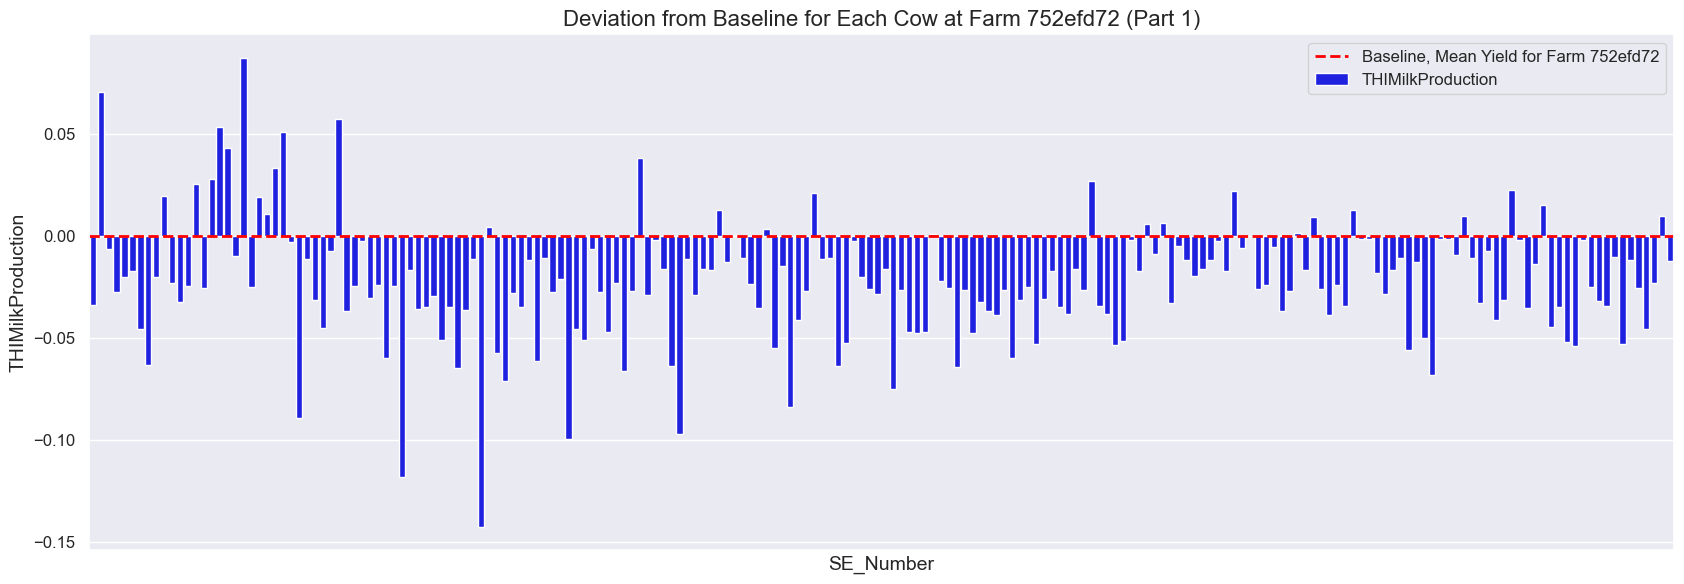

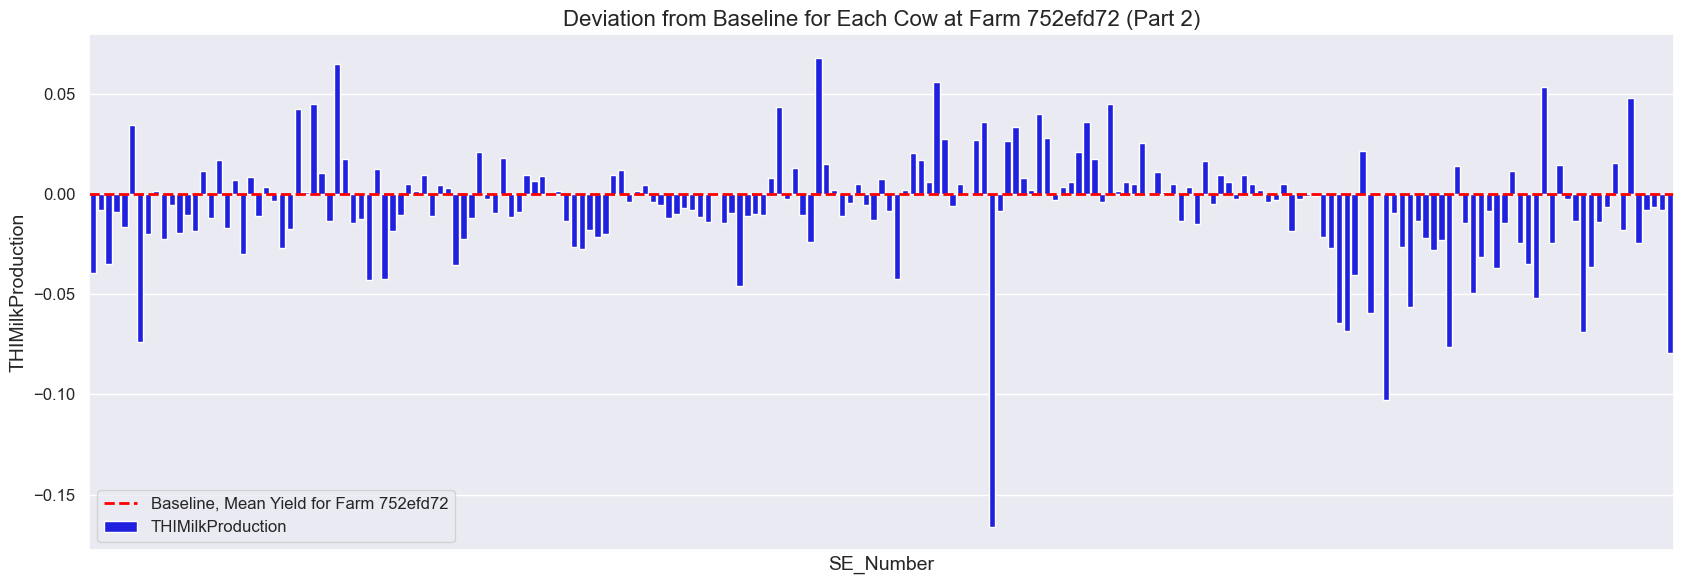

In [17]:
# Calculate the midpoint to split the data into two halves
midpoint = len(results_df) // 2

# Split the data into two halves
first_half = results_df.iloc[:midpoint]
second_half = results_df.iloc[midpoint:]

# Plotting for the first half
plt.figure(figsize=(17, 6))
sns.barplot(x=first_half.index, y=first_half['THIMilkProduction'], color='blue', label='THIMilkProduction')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline, Mean Yield for Farm {farm_id}')
plt.xlabel('SE_Number', fontsize=14)
plt.ylabel('THIMilkProduction', fontsize=14)
plt.title(f'Deviation from Baseline for Each Cow at Farm {farm_id} (Part 1)', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# Plotting for the second half
plt.figure(figsize=(17, 6))
sns.barplot(x=second_half.index, y=second_half['THIMilkProduction'], color='blue', label='THIMilkProduction')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline, Mean Yield for Farm {farm_id}')
plt.xlabel('SE_Number', fontsize=14)
plt.ylabel('THIMilkProduction', fontsize=14)
plt.title(f'Deviation from Baseline for Each Cow at Farm {farm_id} (Part 2)', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

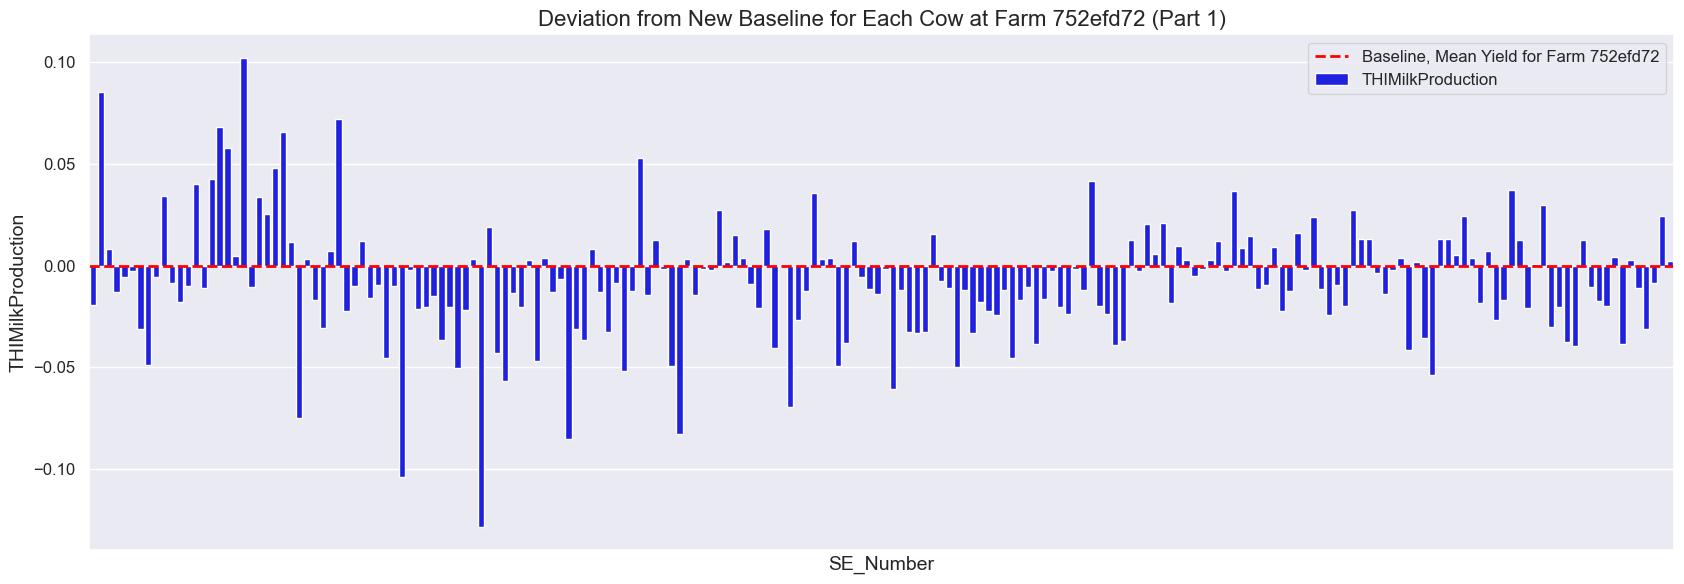

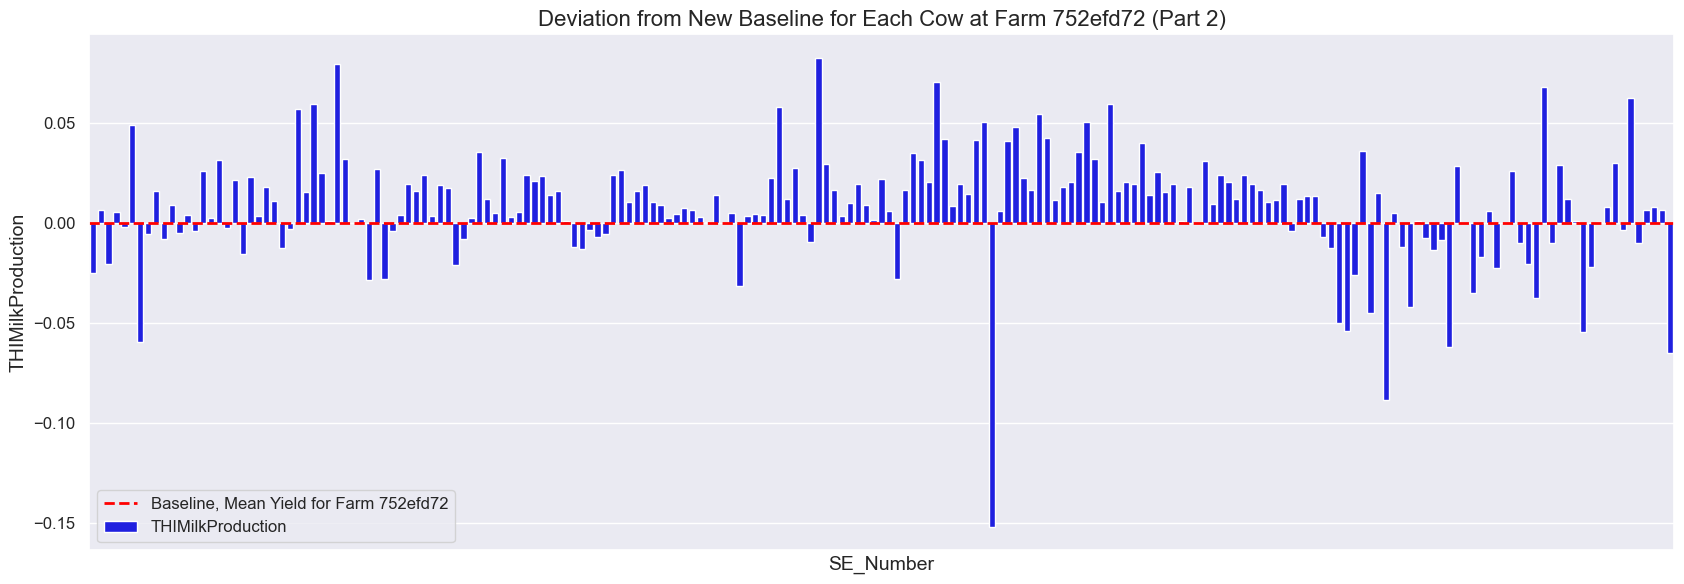

In [18]:
# New baseline value
new_baseline = results_df['THIMilkProduction'].mean()

# Adjust the THIMilkProduction to start from the new baseline
results_df['AdjustedTHIMilkProduction'] = results_df['THIMilkProduction'] - new_baseline

# Calculate the midpoint to split the data into two halves
midpoint = len(results_df) // 2

# Split the data into two halves
first_half = results_df.iloc[:midpoint]
second_half = results_df.iloc[midpoint:]

# Plotting for the first half
plt.figure(figsize=(17, 6))
sns.barplot(x=first_half.index, y=first_half['AdjustedTHIMilkProduction'], color='blue', label='THIMilkProduction')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline, Mean Yield for Farm {farm_id}')
plt.xlabel('SE_Number', fontsize=14)
plt.ylabel('THIMilkProduction', fontsize=14)
plt.title(f'Deviation from New Baseline for Each Cow at Farm {farm_id} (Part 1)', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# Plotting for the second half
plt.figure(figsize=(17, 6))
sns.barplot(x=second_half.index, y=second_half['AdjustedTHIMilkProduction'], color='blue', label='THIMilkProduction')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline, Mean Yield for Farm {farm_id}')
plt.xlabel('SE_Number', fontsize=14)
plt.ylabel('THIMilkProduction', fontsize=14)
plt.title(f'Deviation from New Baseline for Each Cow at Farm {farm_id} (Part 2)', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

## Farm f454e660

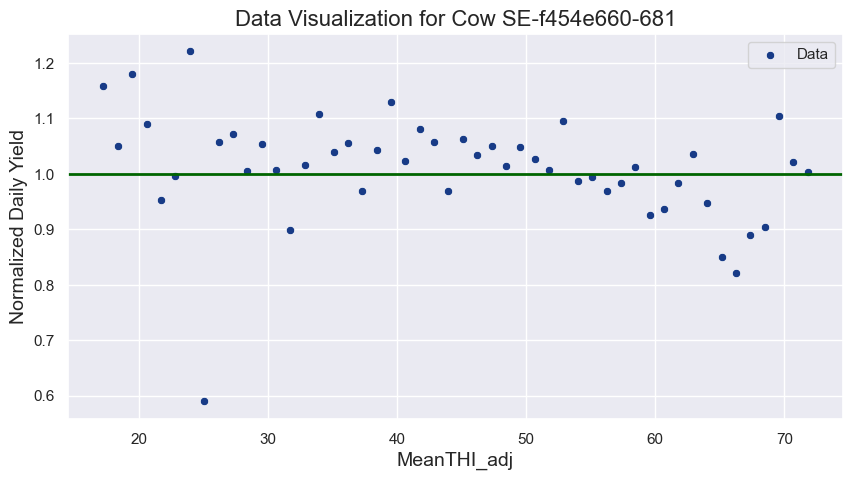

In [19]:
# Filter data for the specific farm
farm_id = 'f454e660'
farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm_id]

# Get unique cows (SE_Number) in the farm
unique_cows = farm_data['SE_Number'].unique()

# Select a random cow for plotting (you can set seed for reproducibility)
np.random.seed(42)  # For reproducibility
random_cow = np.random.choice(unique_cows)

for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]

    # Data Preparation
    N = 50  # Number of bins
    input_feature_label = 'MeanTHI_adj'
    
    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N) 
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Assign target y and input vector x
    x = mean_yields[input_feature_label].values
    y = mean_yields.NormalizedDailyYield.values

    # Calculate mean_yield for this cow
    mean_yield = cow_data['NormalizedDailyYield'].mean()

    # Initial Visualization (for a random cow only)
    if se_number == random_cow:
        fig = plt.figure(figsize=(10, 5))
        ax = plt.subplot(111)
        scatter = sns.scatterplot(x=x, y=y, label='Data', color='#183B87', ax=ax)

        # Add horizontal line for the mean yield
        mean_yield = cow_data['NormalizedDailyYield'].mean()
        ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')
        
        plt.title(f"Data Visualization for Cow {se_number}", fontsize=16)
        plt.xlabel('MeanTHI_adj', fontsize=14)
        plt.ylabel('Normalized Daily Yield', fontsize=14)
        plt.show()

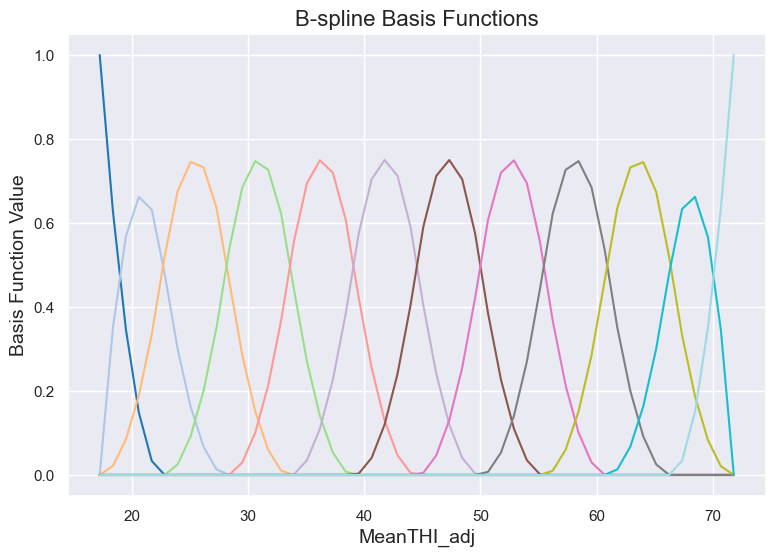

In [20]:
def Phi(a, knots, degree=3, spline_type='B'):
    lower_bound = min(a)
    upper_bound = max(a)
    
    # Adjust knots to ensure they are within the bounds
    knots = np.clip(knots, lower_bound, upper_bound)
    
    if spline_type == 'B':
        B = dmatrix(f"bs(x, knots=knots, degree={degree}, include_intercept=True) - 1", {"x": a, 'knots': knots})
    elif spline_type == 'CR':
        B = dmatrix(f"cr(x, knots=knots, constraints='center')- 1", {"x": a, 'knots': knots})
    elif spline_type == 'CC':
        B = dmatrix(f"cc(x, knots=knots, constraints='center') - 1", {"x": a, 'knots': knots})
    else:
        raise ValueError(f"{spline_type} is not a valid type, choose from 'B', 'CC' or 'CR'")
    return B


for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]
    
    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N) 
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Assign target y and input vector x
    x = mean_yields[input_feature_label].values
    y = mean_yields.NormalizedDailyYield.values

    # Block 2: B-Spline Basis Functions
    degree_spline = 2  # Change the order of the polynomial here
    num_qs = 10
    knot_list = np.quantile(x, q=np.linspace(0, 1, num_qs+1)[1:-1])

    B = Phi(x, knots=knot_list, degree=degree_spline, spline_type='B')

    # Plot Basis Functions (for the random cow)
    if se_number == random_cow:
        color_map = plt.colormaps.get_cmap('tab20')
        colors = color_map(np.linspace(0, 1, B.shape[1]))

        fig = plt.figure(figsize=(9, 6))
        ax = plt.subplot(111)
        for i in range(B.shape[1]):
            c = colors[i]
            ax.plot(x, B[:, i], c=c, label=f'Basis {i + 1}')

        plt.title('B-spline Basis Functions', fontsize=16)
        plt.xlabel('MeanTHI_adj', fontsize=14)
        plt.ylabel('Basis Function Value', fontsize=14)
        plt.show()

Mean squared error for Cow SE-f454e660-681 is 0.0070


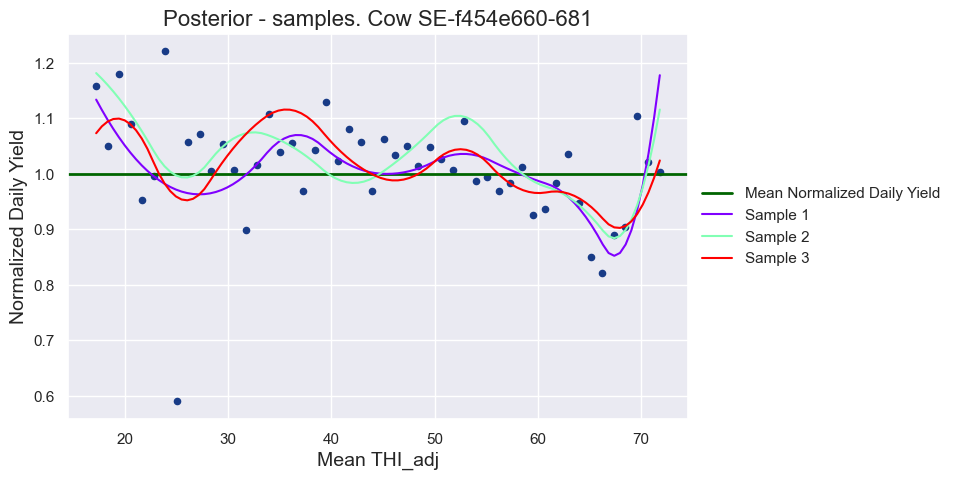

In [21]:
# Seed for reproducibility
np.random.seed(42)

# Select a random cow for plotting
random_cow = np.random.choice(unique_cows)

for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]

    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N)
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Assign target y and input vector x
    x = mean_yields[input_feature_label].values
    y = mean_yields.NormalizedDailyYield.values

    # Check if there are enough data points
    if len(y) < 2:  # If fewer than 2 data points, skip this cow
        print(f"Skipping Cow {se_number} due to insufficient data points.")
        continue

    # Block 2: B-Spline Basis Functions
    degree_spline = 2  # Change the order of the polynomial here
    num_qs = 10
    knot_list = np.quantile(x, q=np.linspace(0, 1, num_qs + 1)[1:-1])

    B = Phi(x, knots=knot_list, degree=degree_spline, spline_type='B')

    # Block 3: Bayesian Linear Regression - GAM
    # Calculate empirical priors from the data
    D = B.shape[1]
    m0 = np.linalg.lstsq(B, y, rcond=None)[0]  # Least-squares estimate as prior mean
    S0 = np.cov(B.T)  # Covariance of the design matrix as prior covariance

    if np.any(np.isnan(S0)) or np.any(np.isinf(S0)):
        print(f"Skipping Cow {se_number} due to invalid covariance matrix.")
        continue

    beta = 1 / np.var(y)

    if np.isinf(beta) or np.isnan(beta):
        print(f"Skipping Cow {se_number} due to invalid beta value.")
        continue

    # Compute the posterior distribution with new priors
    SN = pinv(pinv(S0) + beta * B.T @ B)

    # Adding a small regularization term to ensure positive semi-definiteness
    regularization_term = 1e-6 * np.eye(D)
    SN += regularization_term

    mN = SN @ (pinv(S0) @ m0 + beta * B.T @ y)

    # Print MSE for this cow
    mse = np.mean((y - B @ mN) ** 2)

    # Plot the posterior for the random cow
    if se_number == random_cow:
        print(f"Mean squared error for Cow {se_number} is {mse:.4f}")
        samples = 3
        seed = 100
        ws = multivariate_normal(mean=mN, cov=SN, allow_singular=True).rvs(samples, random_state=seed)

        n = 100  # number of grid-points
        xs = np.linspace(x.min(), x.max(), n)
        new_data = {'x': xs}

        B_star = build_design_matrices([B.design_info], new_data)[0]
        B_star = np.asarray(B_star)

        # Compute corresponding values f(x*)
        fs = B_star @ ws.T

        # Plot the samples
        fig = plt.figure(figsize=(10, 5))
        ax = plt.subplot(111)
        plt.scatter(x, y, color='#183B87', zorder=1, s=20)

        # Add horizontal line for the mean yield
        mean_yield = cow_data['NormalizedDailyYield'].mean()
        ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')

        color = cycle(cm.rainbow(np.linspace(0, 1, samples)))
        for i in range(ws.shape[0]):
            c = next(color)
            line, = ax.plot(xs, fs[:, i], c=c, label=f"Sample {i+1}")

        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), framealpha=0)  # Set legend transparency

        plt.title(f'Posterior - samples. Cow {se_number}', fontsize=16)
        plt.xlabel(re.sub(r'([a-z])([A-Z])', r'\1 \2', input_feature_label), fontsize=14)
        plt.ylabel('Normalized Daily Yield', fontsize=14)  # Updated ylabel

        plt.show()

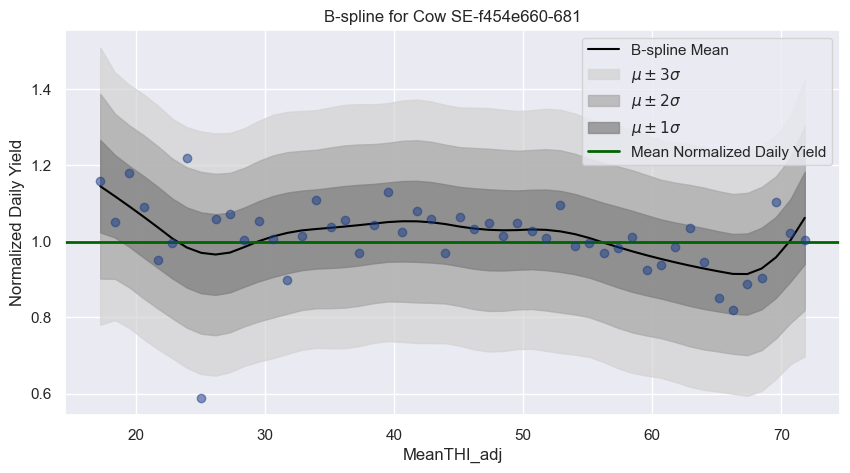

Skipping Cow SE-f454e660-724 due to insufficient data points after filtering.


,FarmName_Pseudo,SE_Number,THIMilkProduction [%],THIMilkProduction
0,f454e660,SE-a2bab923-5680-5,0.902768,0.009028
1,f454e660,SE-f454e660-0139,3.846166,0.038462
2,f454e660,SE-f454e660-0335,0.495010,0.004950
3,f454e660,SE-f454e660-0412,8.277776,0.082778
4,f454e660,SE-f454e660-0465,-3.356541,-0.033565
...,...,...,...,...
185,f454e660,SE-f454e660-747,3.926065,0.039261
186,f454e660,SE-f454e660-750,0.816147,0.008161
187,f454e660,SE-f454e660-787,-0.446699,-0.004467
188,f454e660,SE-f454e660-799,6.197212,0.061972


In [22]:
# Seed for reproducibility
np.random.seed(42)

# Initialize an empty DataFrame to store results
results_df = pd.DataFrame(columns=['FarmName_Pseudo', 'SE_Number', 'THIMilkProduction [%]'])

# Select a random cow for plotting
random_cow = np.random.choice(unique_cows)

for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]

    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N)
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Convert bin_midpoints to numeric for comparison
    x = mean_yields[input_feature_label].values.astype(float)
    y = mean_yields.NormalizedDailyYield.values

    # Ensure sufficient data points
    if len(y) < 2:  # Ensure at least 2 data points
        print(f"Skipping Cow {se_number} due to insufficient data points.")
        continue

    try:
        # B-Spline Basis Functions (Primary Method)
        degree_spline = 2  # Change the order of the polynomial here
        max_knots = min(len(y) - 1, 10)
        num_qs = max_knots
        knot_list = np.quantile(x, q=np.linspace(0, 1, num_qs + 1)[1:-1])
        B = Phi(x, knots=knot_list, degree=degree_spline, spline_type='B')

        # Check if B has more rows than columns
        if B.shape[0] < B.shape[1]:
            raise ValueError(f"Incompatible dimensions (B: {B.shape})")

        # Step 1: Calculate empirical priors from the correct data
        m0 = np.linalg.lstsq(B, y, rcond=None)[0]  # Least-squares estimate as prior mean
        S0 = np.cov(B.T)  # Covariance of the design matrix as prior covariance

        if np.any(np.isnan(S0)) or np.any(np.isinf(S0)):
            print(f"Skipping Cow {se_number} due to invalid covariance matrix.")
            continue

        # Bayesian Linear Regression
        beta = 1 / np.var(y)
        lambda_ridge = 0.1
        SN = np.linalg.pinv(np.linalg.pinv(S0) + beta * B.T @ B + lambda_ridge * np.eye(B.shape[1]))
        mN = SN @ (np.linalg.pinv(S0) @ m0 + beta * B.T @ y)

        # Make predictions
        mstar_mle = B @ mN
        Sstar_mle = B @ SN @ B.T + beta ** (-1) * np.eye(B.shape[0])
        stdpred_mle = np.sqrt(np.diag(Sstar_mle))
        model_type = 'B-spline'

    except Exception as e:
        print(f"Skipping Cow {se_number} due to incompatible dimensions or another error: {str(e)}")
        continue

    # Filter x and corresponding mstar_mle for values >= 61
    filtered_indices = x >= 61  # Only include THI values >= 61
    if np.sum(filtered_indices) < 2:
        print(f"Skipping Cow {se_number} due to insufficient data points after filtering.")
        continue

    filtered_xs = x[filtered_indices]
    filtered_mstar_mle = mstar_mle[filtered_indices]

    # Integration to calculate THIMilkProduction
    above_mean = np.maximum(filtered_mstar_mle - mean_yield, 0)
    below_mean = np.maximum(mean_yield - filtered_mstar_mle, 0)

    # Integrate over the filtered x values
    area_above_mean = simpson(above_mean, x=filtered_xs)
    area_below_mean = simpson(below_mean, x=filtered_xs)

    # Calculate the net area (above - below)
    net_area = area_above_mean - area_below_mean
    range_mean_temperature = filtered_xs[-1] - filtered_xs[0]
    net_effect_per_unit = net_area / range_mean_temperature

    # Express the net effect as a percentage of the mean yield
    net_effect_percentage = (net_effect_per_unit / mean_yield) * 100

    # Store results in the DataFrame
    new_result = pd.DataFrame([{
        'FarmName_Pseudo': farm_id,
        'SE_Number': se_number,
        'THIMilkProduction [%]': net_effect_percentage
    }])

    if results_df.empty:
        results_df = new_result
    else:
        results_df = pd.concat([results_df, new_result], ignore_index=True)

    # Plot for the randomly selected cow
    if se_number == random_cow:
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot(x, mstar_mle, 'black', label=f'{model_type} Mean')
        ax.fill_between(x, mstar_mle + 3*stdpred_mle, mstar_mle - 3*stdpred_mle, color='lightgray', alpha=0.7, label=r'$\mu \pm 3\sigma$')
        ax.fill_between(x, mstar_mle + 2*stdpred_mle, mstar_mle - 2*stdpred_mle, color='darkgray', alpha=0.7, label=r'$\mu \pm 2\sigma$')
        ax.fill_between(x, mstar_mle + 1*stdpred_mle, mstar_mle - 1*stdpred_mle, color='gray', alpha=0.7, label=r'$\mu \pm 1\sigma$')
        ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')
        plt.scatter(x, y, c='#183B87', zorder=4, alpha=0.5)
        ax.legend(loc='best')
        plt.title(f'{model_type} for Cow {se_number}')
        plt.xlabel(f'{input_feature_label}')
        plt.ylabel('Normalized Daily Yield')
        plt.show()

# Display the results
results_df['THIMilkProduction'] = results_df['THIMilkProduction [%]'] / 100
results_df

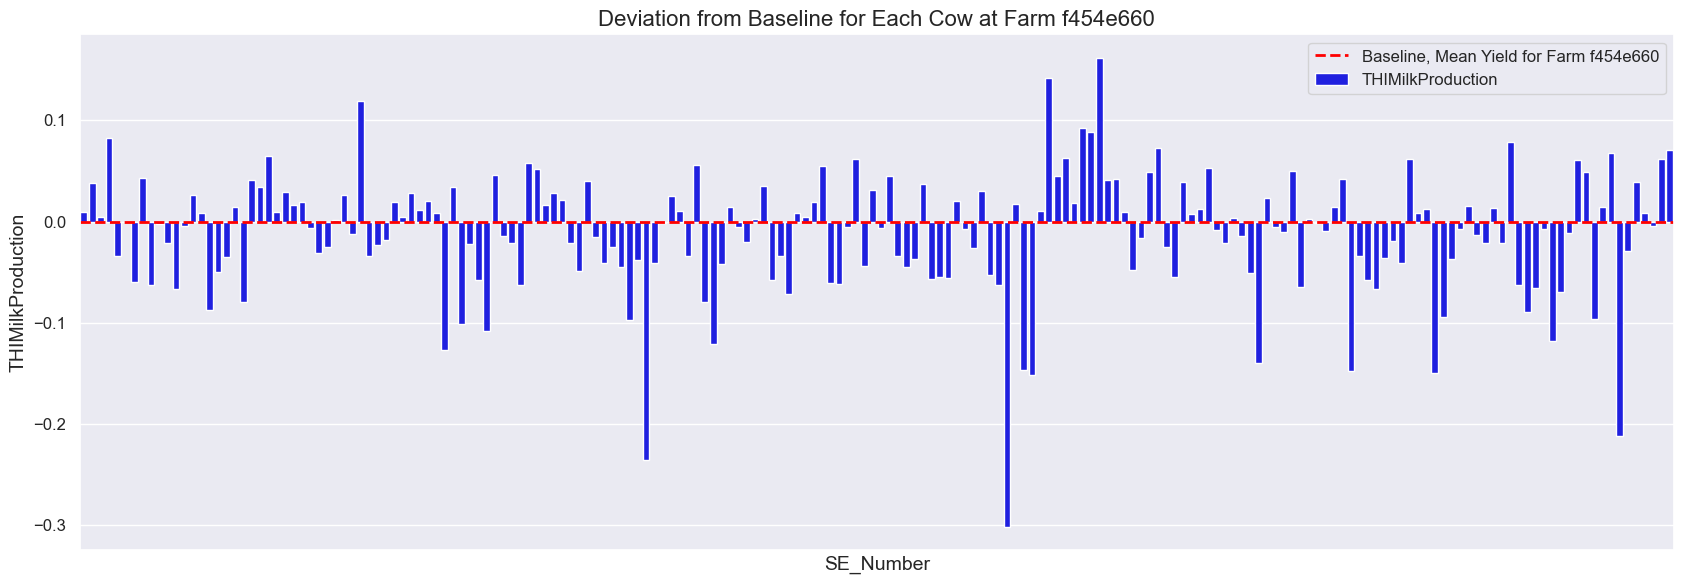

In [23]:
# Create the bar plot
plt.figure(figsize=(17, 6))
sns.barplot(x=results_df.index, y=results_df['THIMilkProduction'], color='blue', label='THIMilkProduction')

# Add a baseline line set to 0
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline, Mean Yield for Farm {farm_id}')

# Formatting the plot
plt.xlabel('SE_Number', fontsize=14)
plt.ylabel('THIMilkProduction', fontsize=14)
plt.title(f'Deviation from Baseline for Each Cow at Farm {farm_id}', fontsize=16)

# Optionally, remove x-axis labels if too many entries
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

plt.legend(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

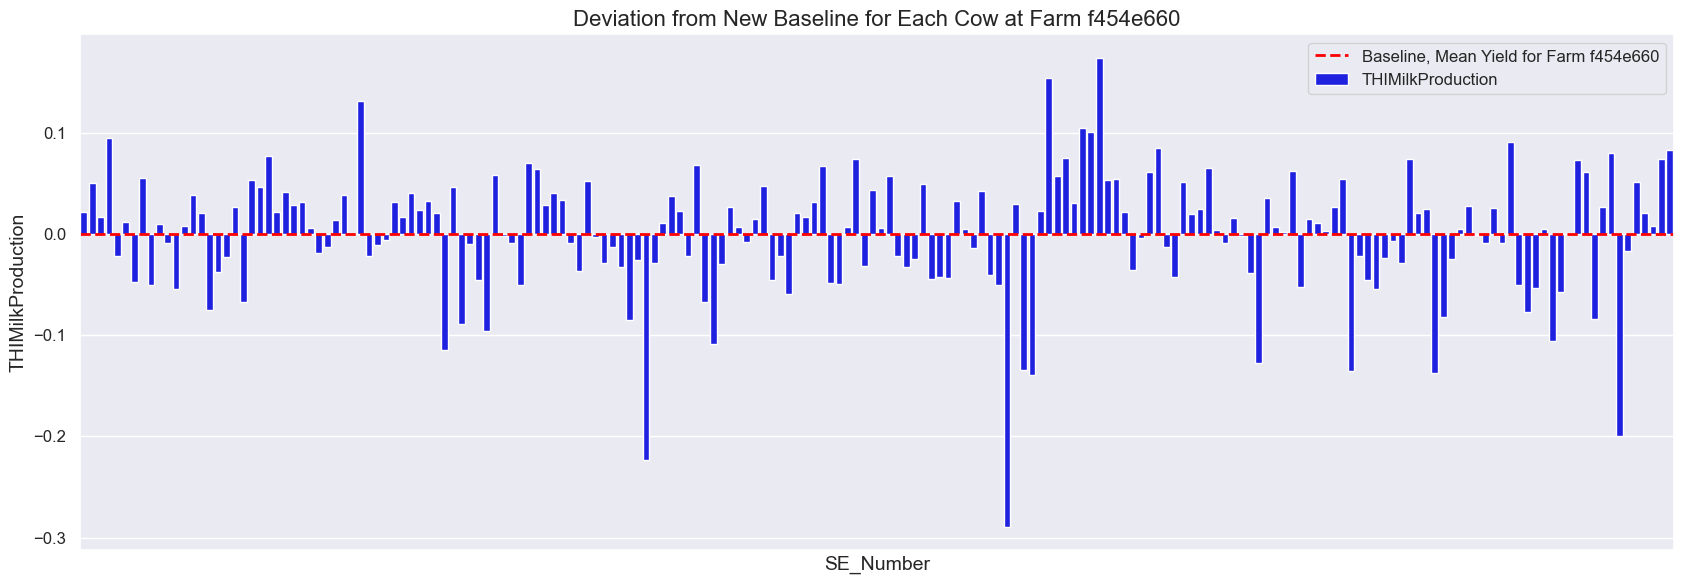

In [24]:
# New baseline value
new_baseline = results_df['THIMilkProduction'].mean()

# Adjust the THIMilkProduction to start from the new baseline
results_df['AdjustedTHIMilkProduction'] = results_df['THIMilkProduction'] - new_baseline

# Create the bar plot
plt.figure(figsize=(17, 6))
sns.barplot(x=results_df.index, y=results_df['AdjustedTHIMilkProduction'], color='blue', label='THIMilkProduction')

# Add a baseline line set to 0 (now adjusted to the new baseline)
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline, Mean Yield for Farm {farm_id}')

# Formatting the plot
plt.xlabel('SE_Number', fontsize=14)
plt.ylabel('THIMilkProduction', fontsize=14)
plt.title(f'Deviation from New Baseline for Each Cow at Farm {farm_id}', fontsize=16)

# Optionally, remove x-axis labels if too many entries
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

plt.legend(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()